In [133]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# importing libraries/modules, and functions
import pandas as pd
import numpy as np
import scipy.stats as stats

# visualization libraries
import matplotlib as mlp
mlp.rcParams['figure.dpi'] = 200
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# created zillow library and functions
from wrangle import get_zillow_dataset, clean_zillow_dataset, zillow_outliers, train_validate_test_split

# sklearn library for data science
import sklearn

# just in case :) 
import env
from env import user, password, host, get_connection

----
``In these exercises, you will run through the stages of exploration as you continue to work toward the above goal.``

3. Write a function named plot_variable_pairs that accepts a dataframe as input and plots all of the pairwise relationships along with the regression line for each pair.



5. Save the functions you have written to create visualizations in your explore.py file. Rewrite your notebook code so that you are using the functions imported from this file.

6. Use the functions you created above to explore your Zillow train dataset in your explore.ipynb notebook.

7. Come up with some initial hypotheses based on your goal of predicting property value.

8. Visualize all combinations of variables in some way.

9. Run the appropriate statistical tests where needed.

10. What independent variables are correlated with the dependent variable, home value?

11. Which independent variables are correlated with other independent variables (bedrooms, bathrooms, year built, square feet)?

12. Make sure to document your takeaways from visualizations and statistical tests as well as the decisions you make throughout your process.

13. Explore your dataset with any other visualizations you think will be helpful.

----
#### ``Importing the "2017 properties" dataset for single family homes``

- creating a csv for future exploration
- this should help to better understand future analysis done on this dataset

In [134]:
# creating the sql query to import all columns from the 2017 zillow properties dataset

# query = ''' 
# SELECT *
# FROM properties_2017
# JOIN propertylandusetype using (propertylandusetypeid)
# WHERE propertylandusedesc = "Single Family Residential"
# '''

# creating sql url
# url = get_connection(user, password, host, "zillow" )

# creating the dataframe
# df = pd.read_sql(query, url)

# generating a .csv file and sending to local directory
# df.to_csv("/Users/mijailmariano/codeup-data-science/regression-exercises/full_zillow.csv")

----
``1. As with encoded vs. unencoded data, we recommend exploring un-scaled data in your EDA process.``

``2. Make sure to perform a train, validate, test split before and use only your train dataset to explore the relationships between independent variables with other independent variables or independent variables with your target variable.``


In [135]:
# importing and cleaning zillow dataset
zillow_df = get_zillow_dataset()
zillow_df = clean_zillow_dataset(zillow_df)

print(f'Initial zillow dataset shape: {zillow_df.shape}')
zillow_df.head(5)

Initial zillow dataset shape: (2140235, 7)


bedroom_count  bath_count  finished_sq_feet  year_built  fips  tax_amount  \
4               4         2.0            3633.0        2005  6037     6941.39   
6               3         4.0            1620.0        2011  6037    10244.94   
7               3         2.0            2077.0        1926  6037     7924.68   
11              0         0.0            1200.0        1972  6037       91.60   
14              0         0.0             171.0        1973  6037      255.17   

    home_value  
4     296425.0  
6     847770.0  
7     646760.0  
11      5328.0  
14      6920.0

In [136]:
# handling outliers 
zillow_df = zillow_outliers(zillow_df)
zillow_df.shape

(2065188, 7)

In [137]:
# splitting the data into train, validate, and test
train, validate, test = train_validate_test_split(zillow_df)

print(f'trains shape: {train.shape}')
print(f'validate shape: {validate.shape}')
print(f'test shape: {test.shape}')

trains shape: (1156505, 7)
validate shape: (495645, 7)
test shape: (413038, 7)


In [138]:
# setting independent/dependent variables in ea. sub-dataset

X_train = train.drop(columns=["home_value", "tax_amount"])
y_train = train.home_value

X_validate = validate.drop(columns=["home_value", "tax_amount"])
y_validate = validate.home_value

X_test = test.drop(columns=["home_value", "tax_amount"])
y_test = test.home_value

-----
#### ``Uni/Multivariate Exploration:``

In [139]:
col_lst = list(X_train.columns)
col_lst

['bedroom_count', 'bath_count', 'finished_sq_feet', 'year_built', 'fips']

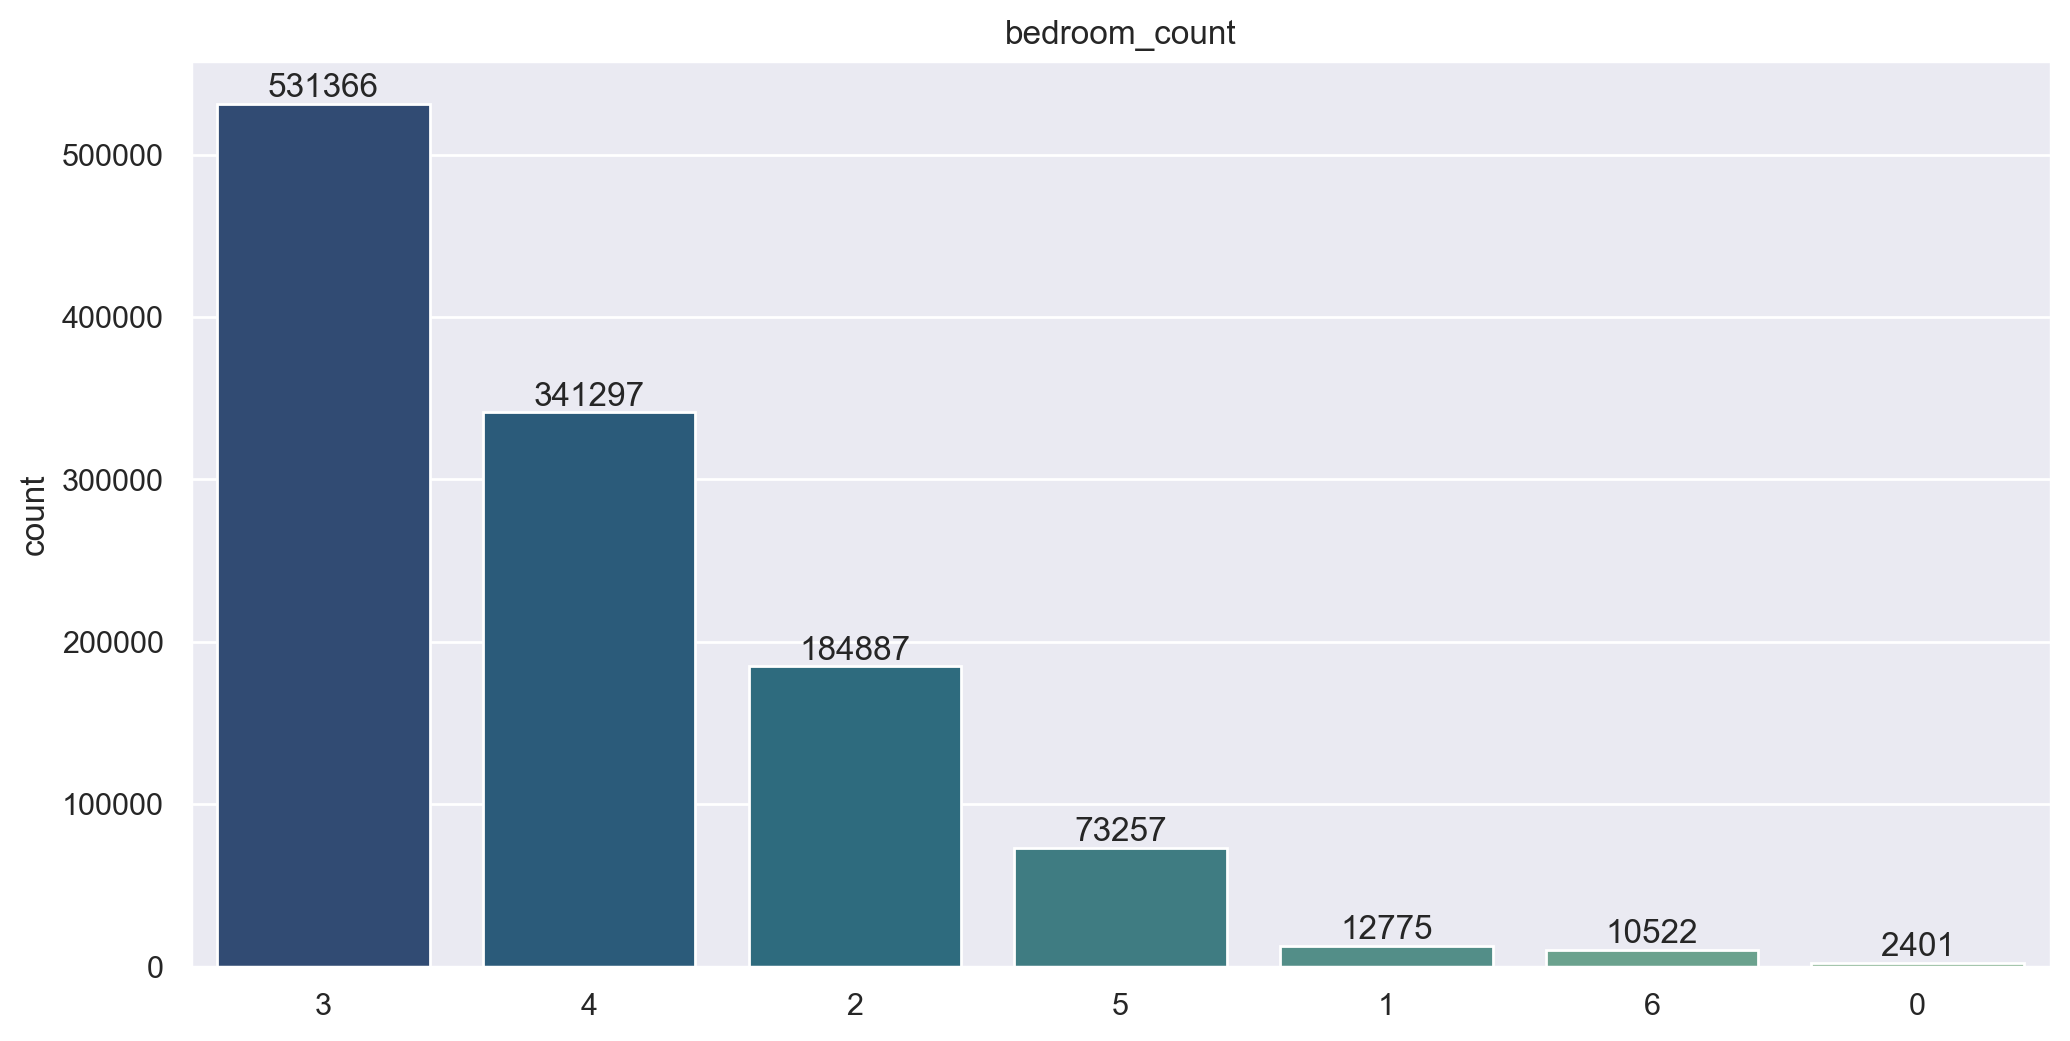

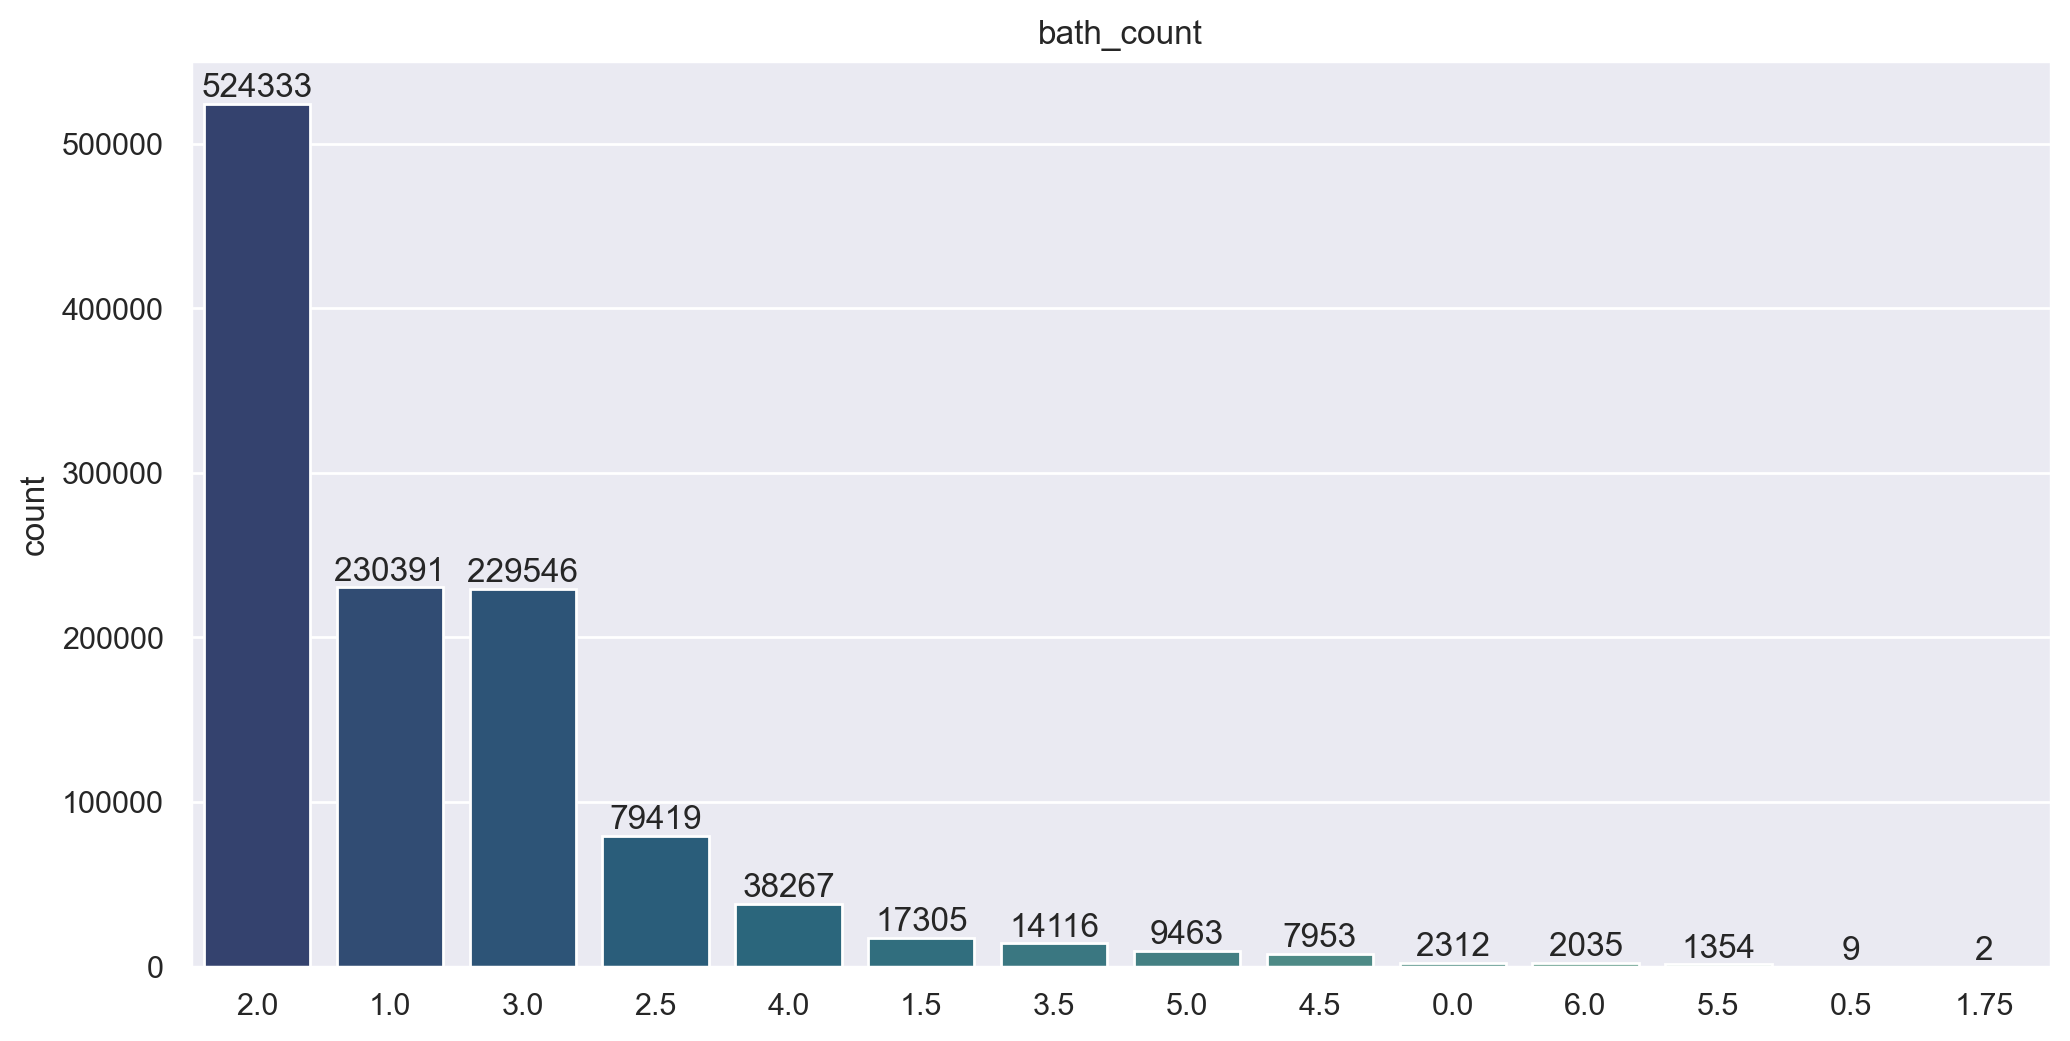

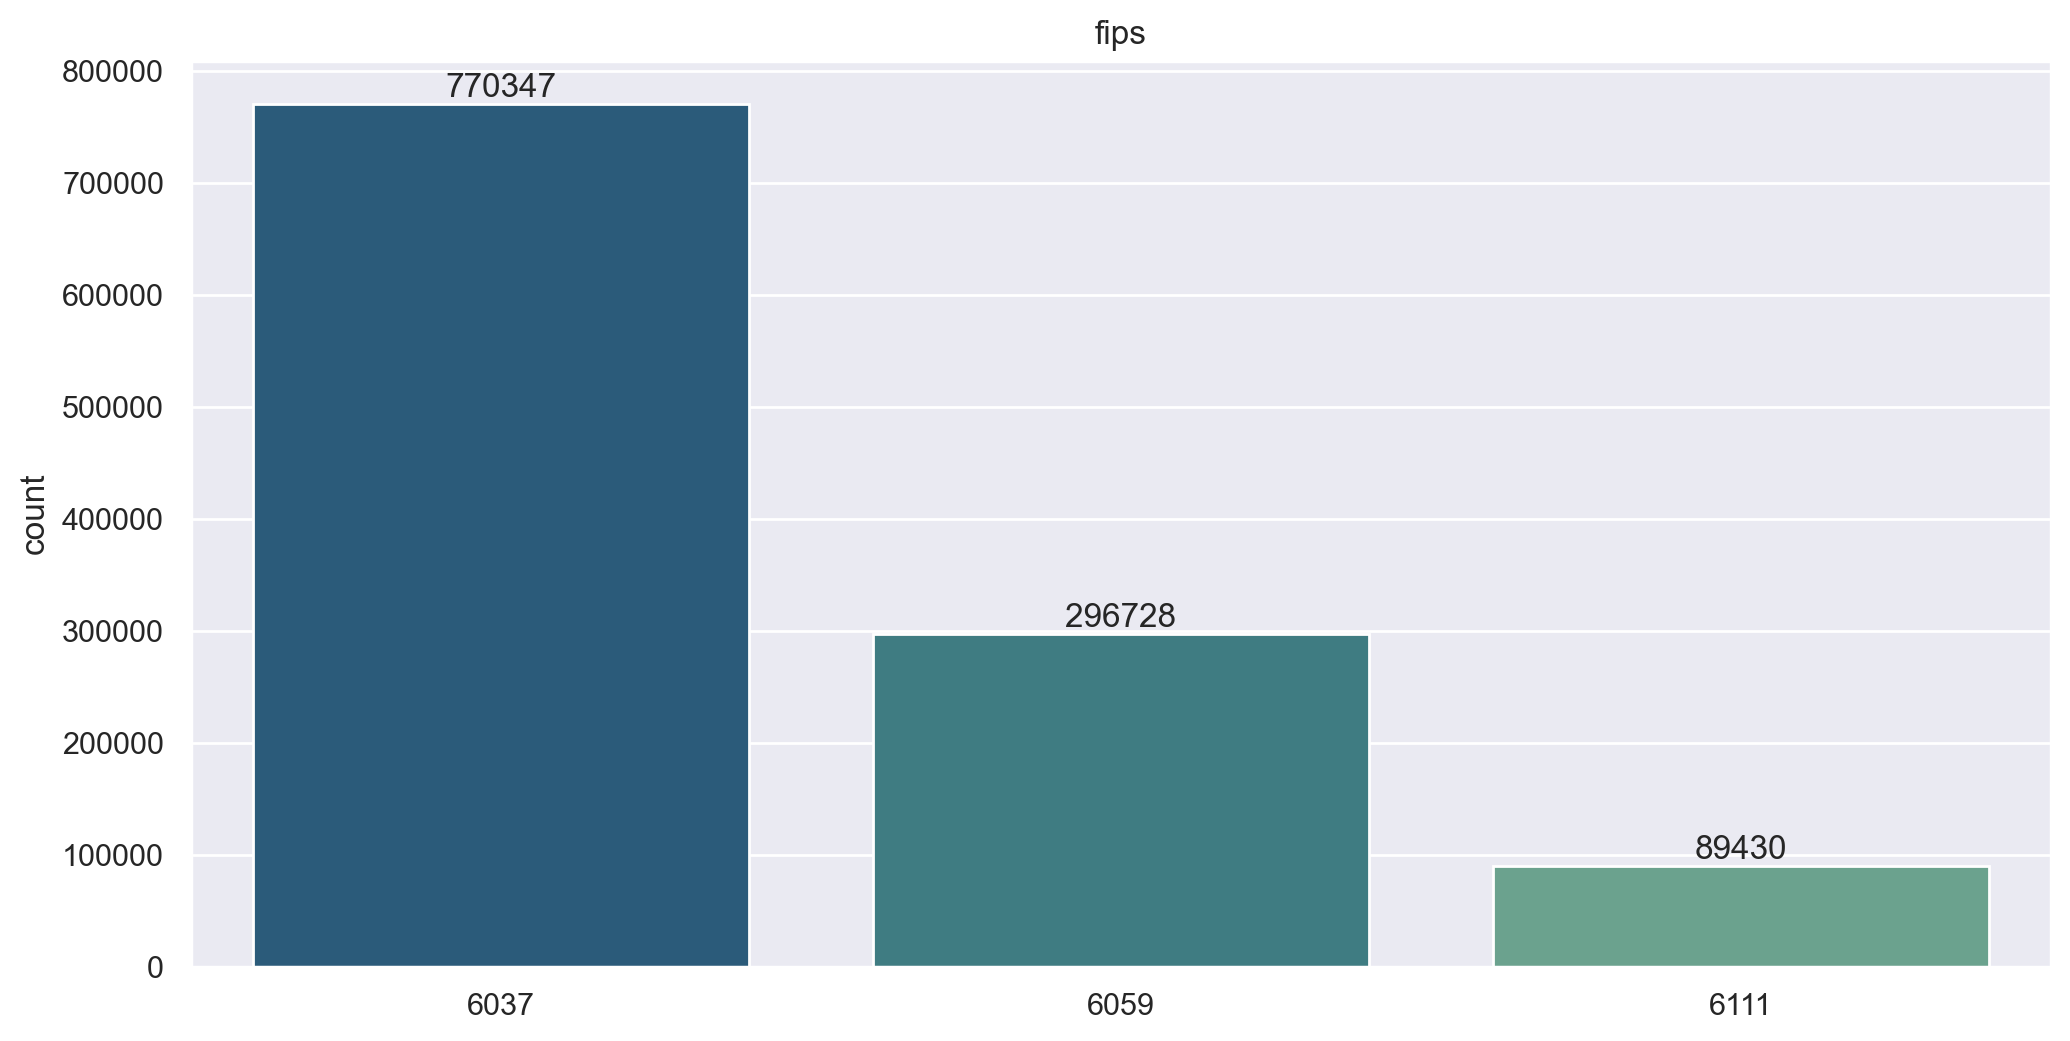

In [140]:
# count/freqeuncy plot for bedroom, bath, and "fips" columns
# consider creating a function that can execute this action in the future**

for column in X_train[["bedroom_count", "bath_count", "fips"]]:
    plt.figure(figsize=(12, 6))
    sns.set(font_scale = 1)
    ax = sns.countplot(x = column, 
                    data = X_train,
                    palette = "crest_r",
                    order = X_train[column].value_counts().index)
    ax.bar_label(ax.containers[0])
    ax.set(xlabel = None)
    plt.title(column)
    plt.show()

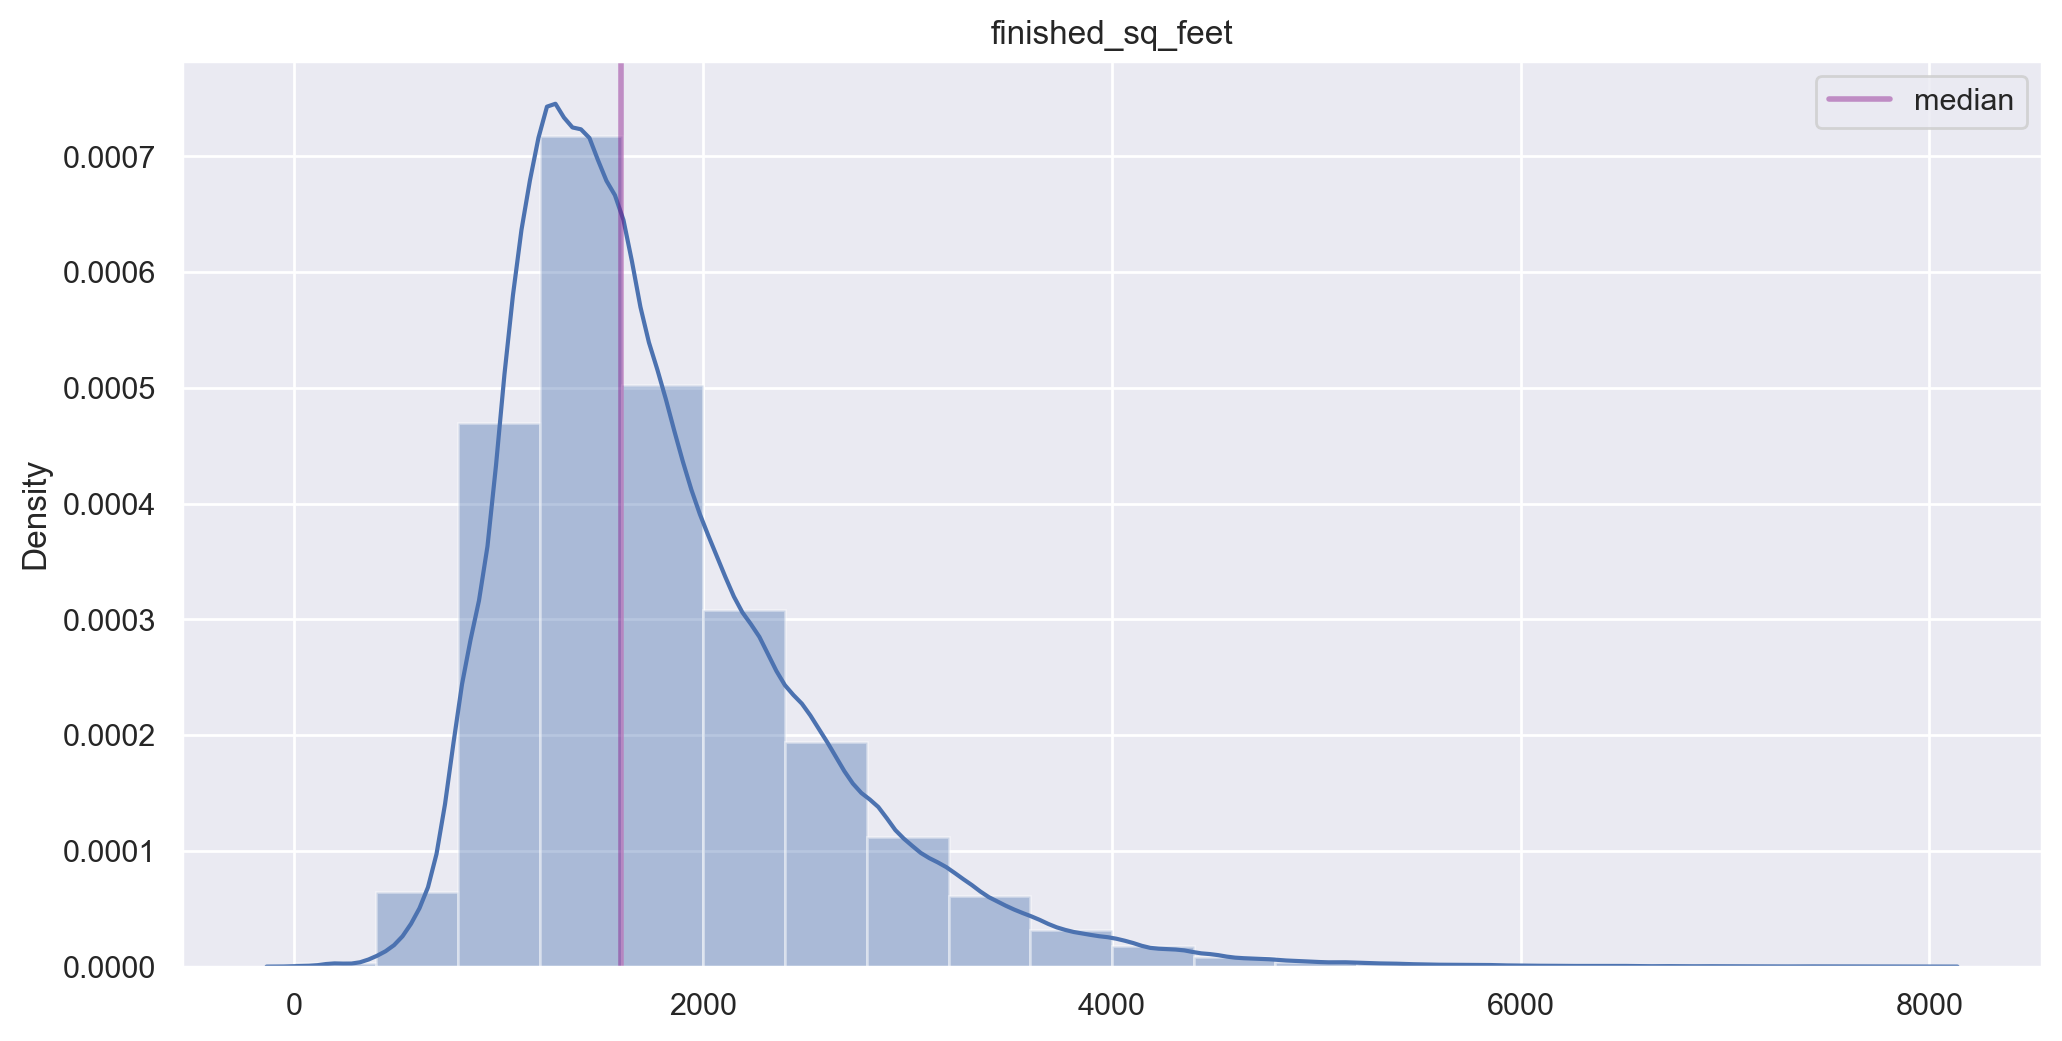

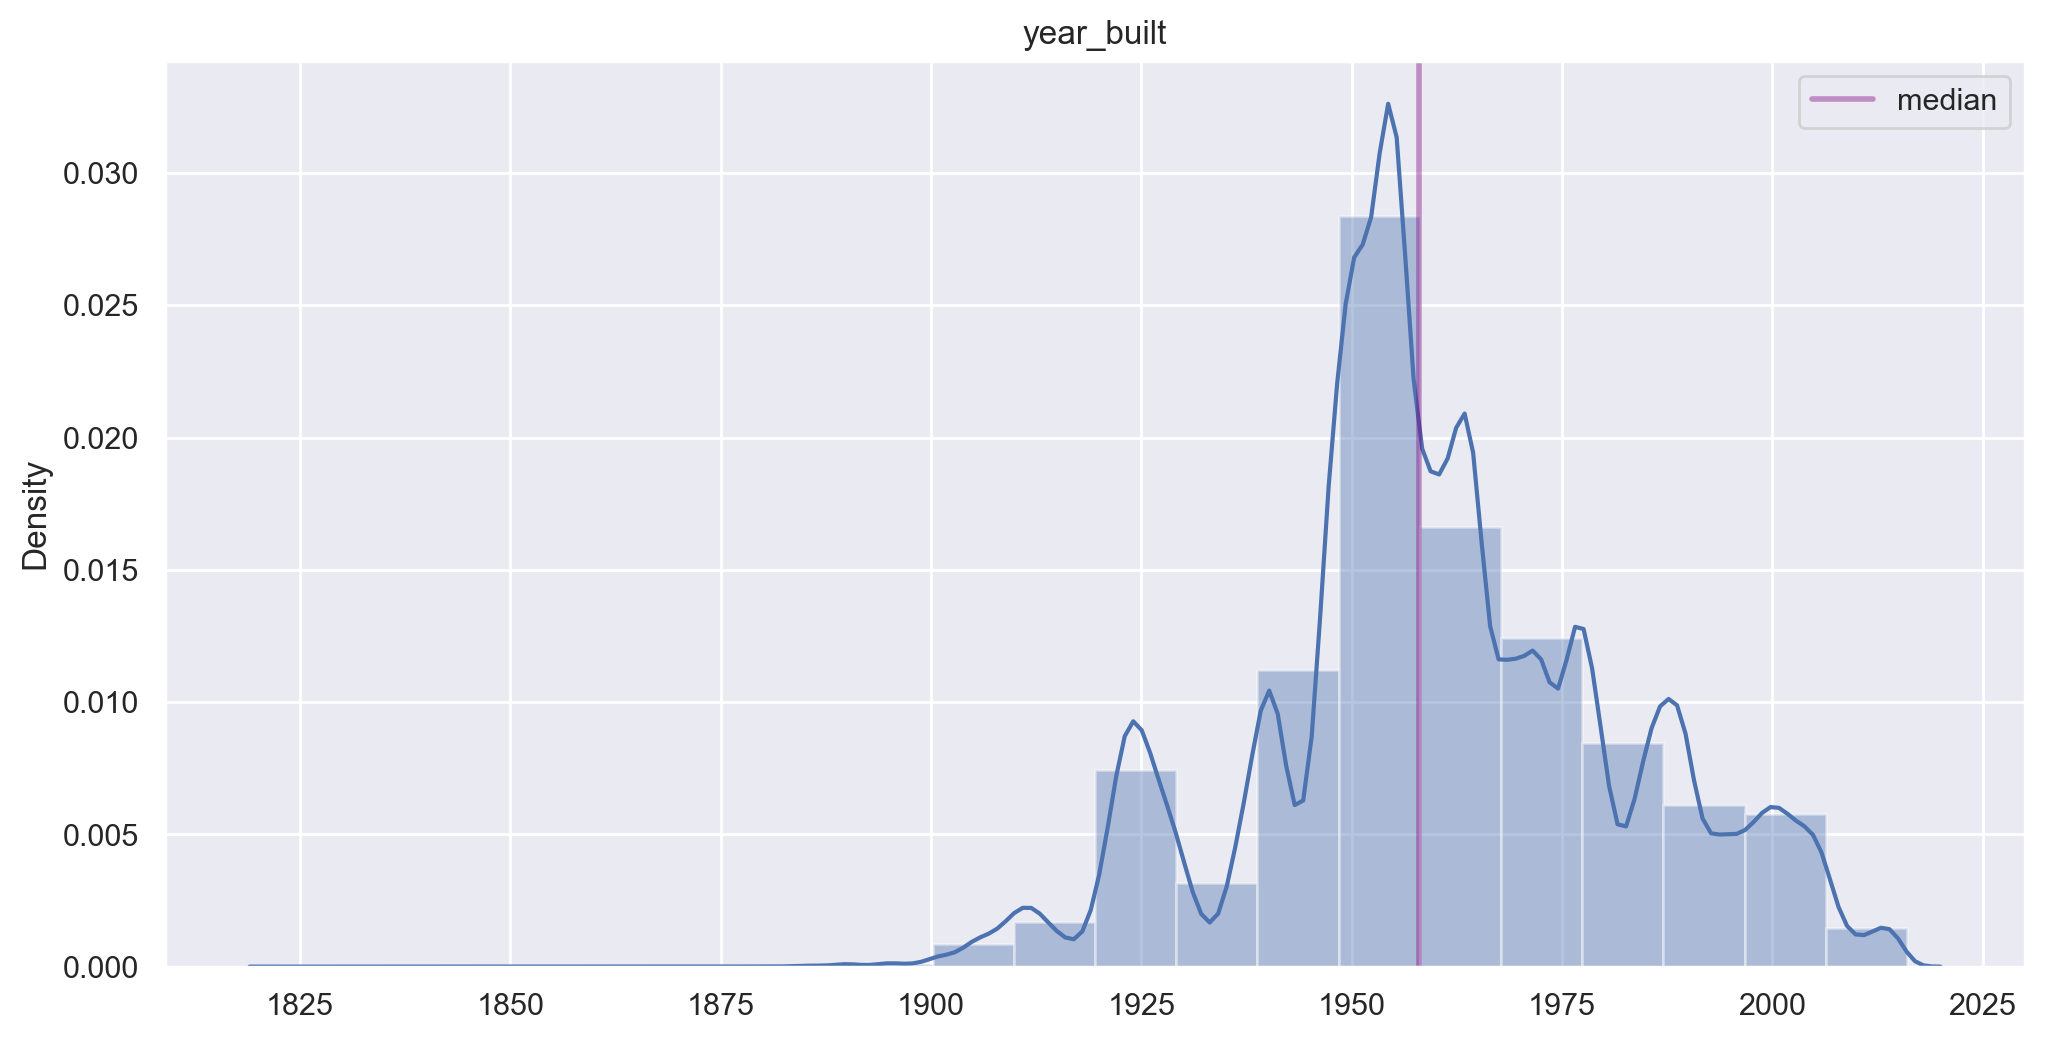

In [141]:
# plotting year built and finished square feet columns
# will consider creating a function that can execute this action in the future**


for column in X_train[["finished_sq_feet", "year_built"]]:
    plt.figure(figsize=(12, 6))
    ax = sns.distplot(x = X_train[column], 
                    bins = 20,
                    kde = True)
    ax.set(xlabel = None)
    plt.axvline(X_train[column].median(), linewidth = 2, color = 'purple', alpha = 0.4, label = "median")
    plt.title(column)
    ax.ticklabel_format(style = "plain") # removing axes scientific notation
    plt.legend()
    plt.show()

----
**``A Note on "Density":``**

(follow-up)

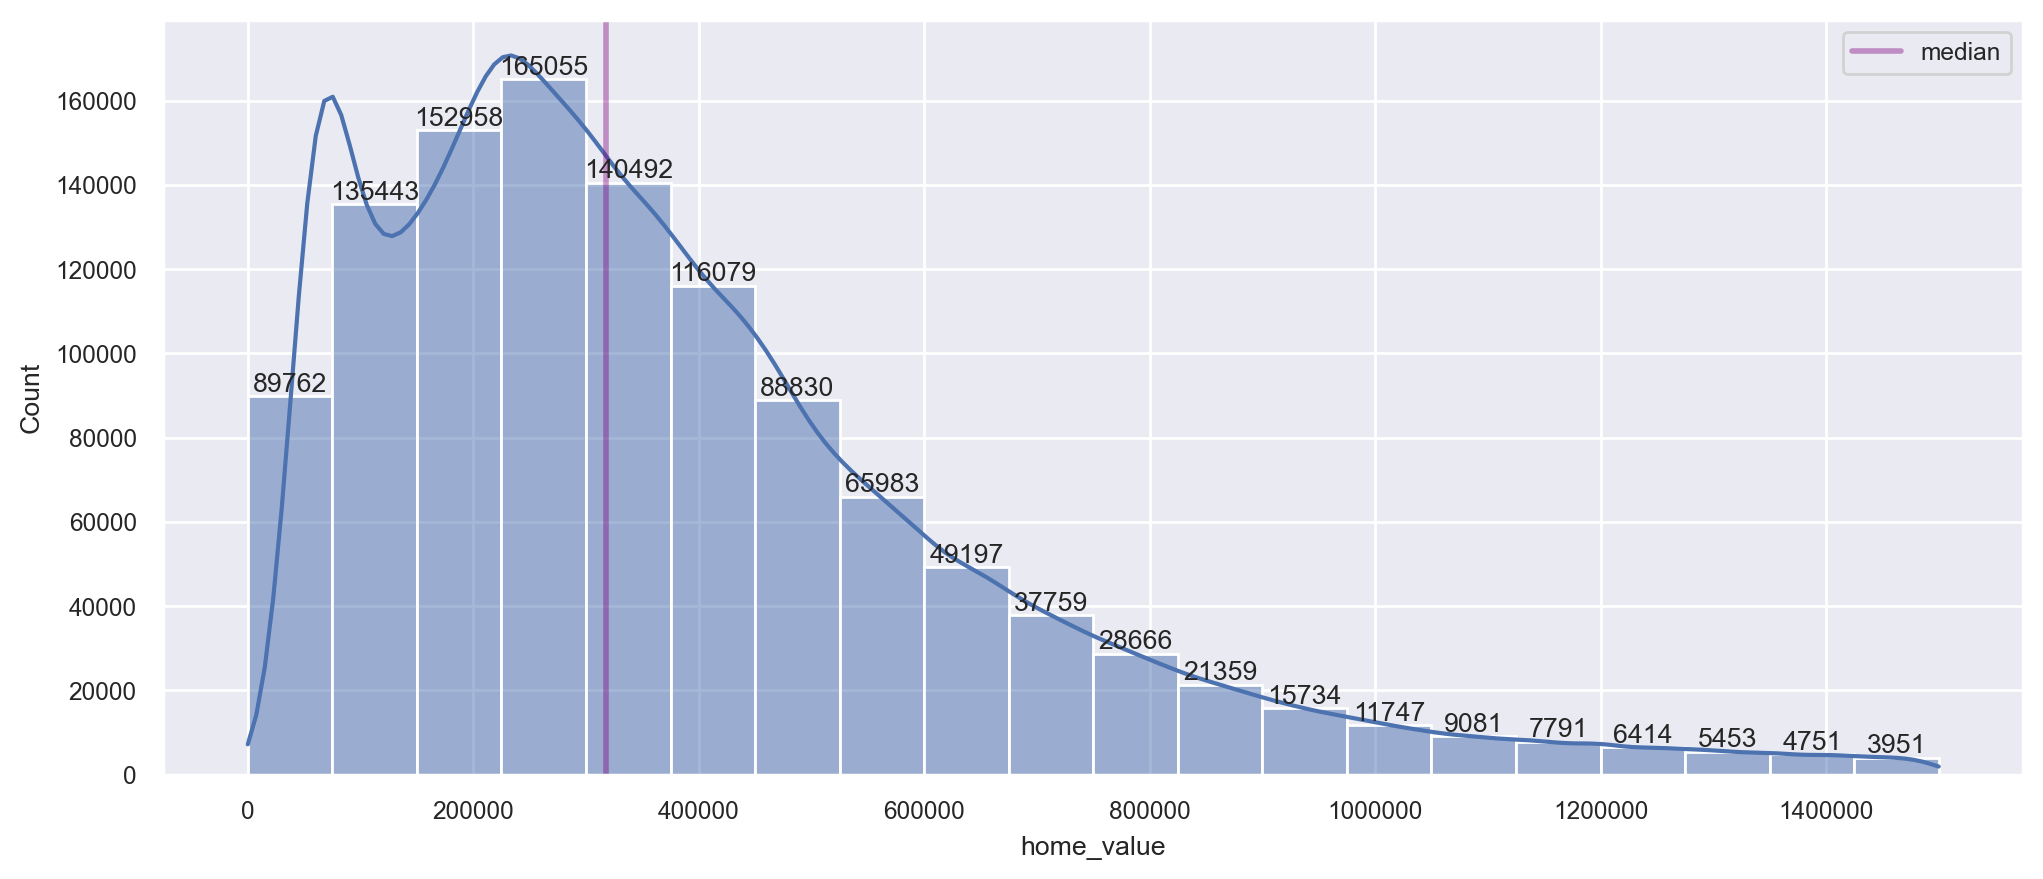

In [142]:
# plotting the target variable

plt.figure(figsize = (12, 5))
sns.set(font_scale = .8)
ax = sns.histplot(y_train, bins = 20, kde = True)

ax.ticklabel_format(style = "plain") # removing axes scientific notation 
ax.bar_label(ax.containers[0])

plt.axvline(y_train.median(), linewidth = 2, color = 'purple', alpha = 0.4, label = "median")
plt.legend()
plt.show()

In [143]:
feature_lst = X_train.columns
feature_lst

Index(['bedroom_count', 'bath_count', 'finished_sq_feet', 'year_built',
       'fips'],
      dtype='object')

In [144]:
X_train.select_dtypes(include = "float").columns

Index(['bath_count', 'finished_sq_feet'], dtype='object')

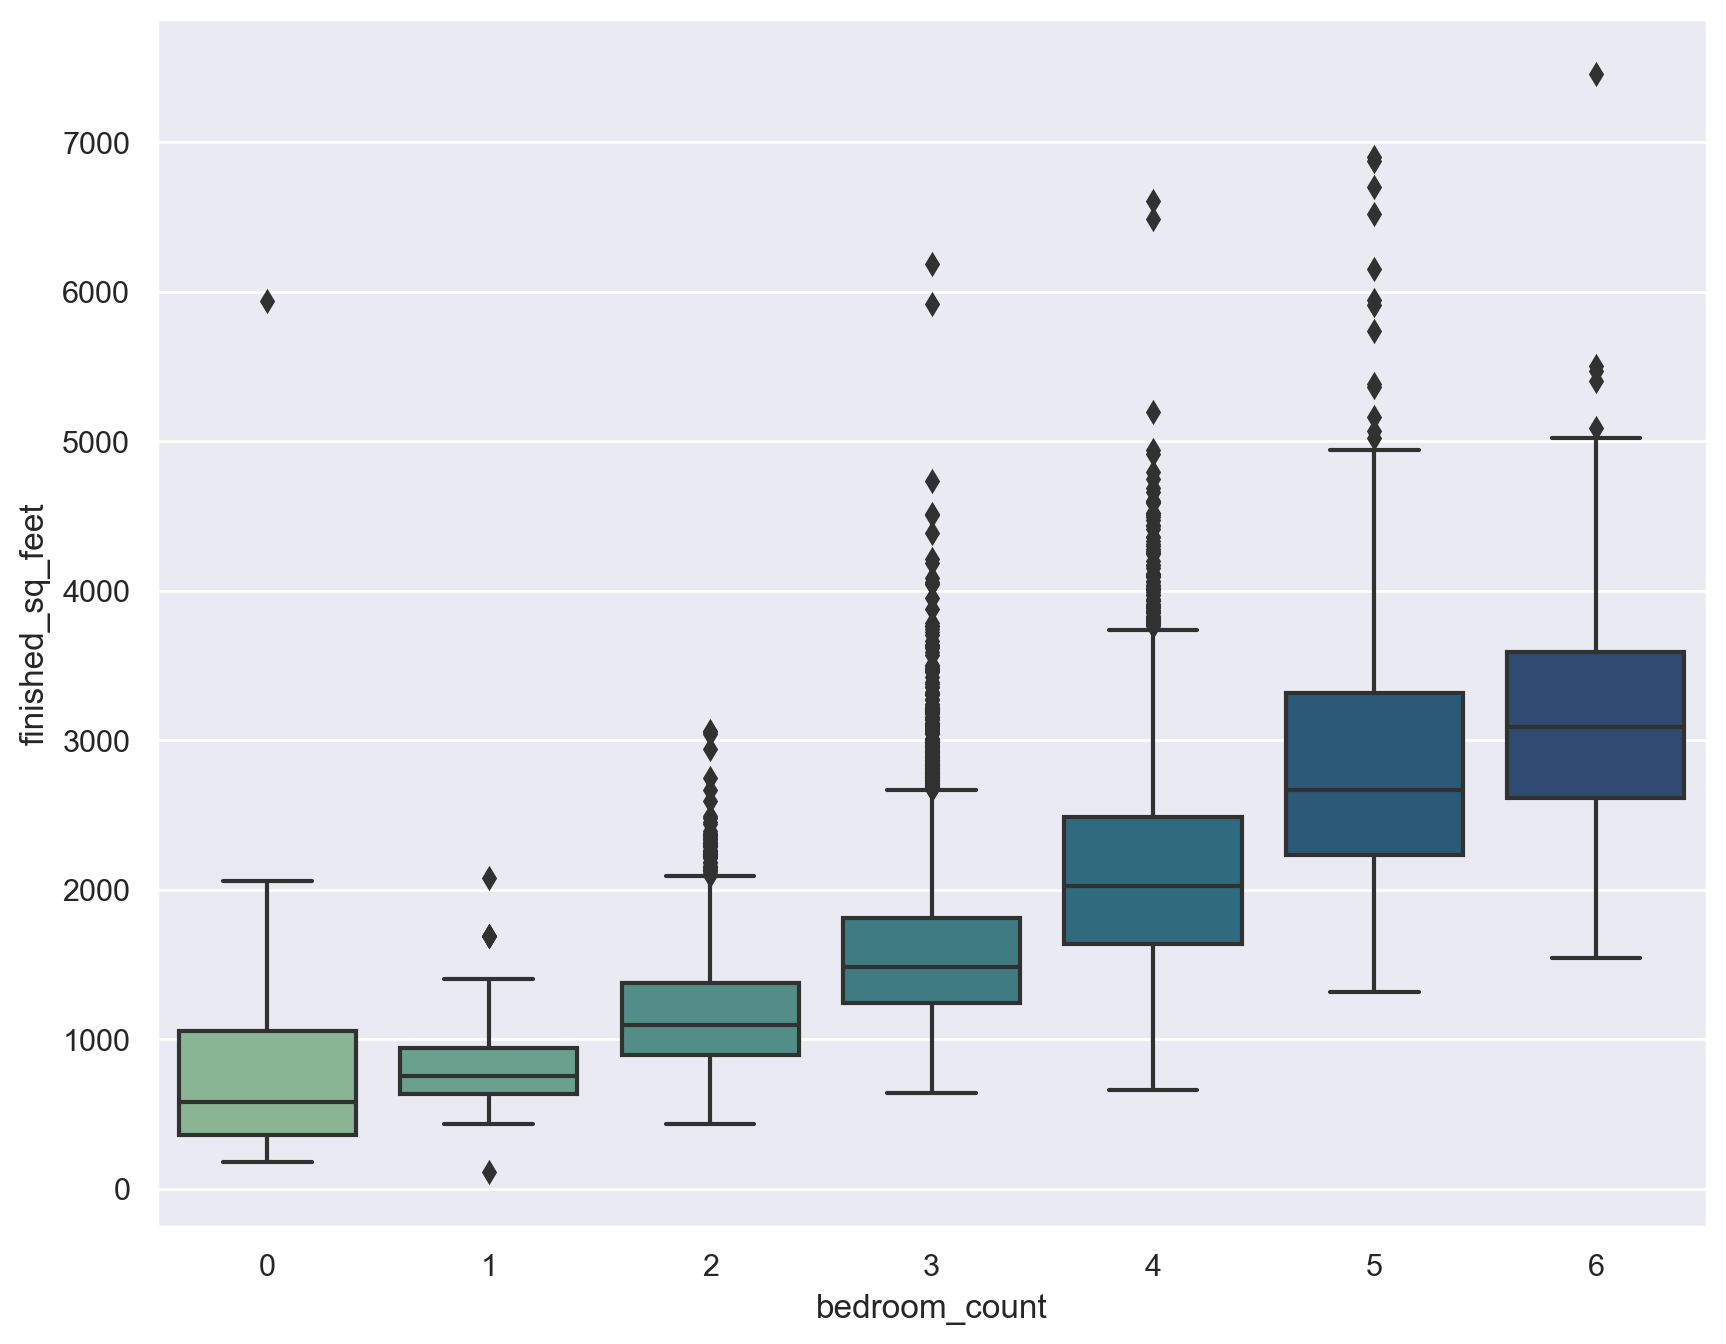

In [145]:
# plotting bedroom against continuous features/variables
# discrete variables: bedroom count, year built
# continuous variables: bath count, finished square feet

plt.figure(figsize = (10, 8))
sns.set(style = "darkgrid")
sns.boxplot(x = "bedroom_count", y = "finished_sq_feet", data = X_train.sample(10000), palette = "crest")
plt.show()

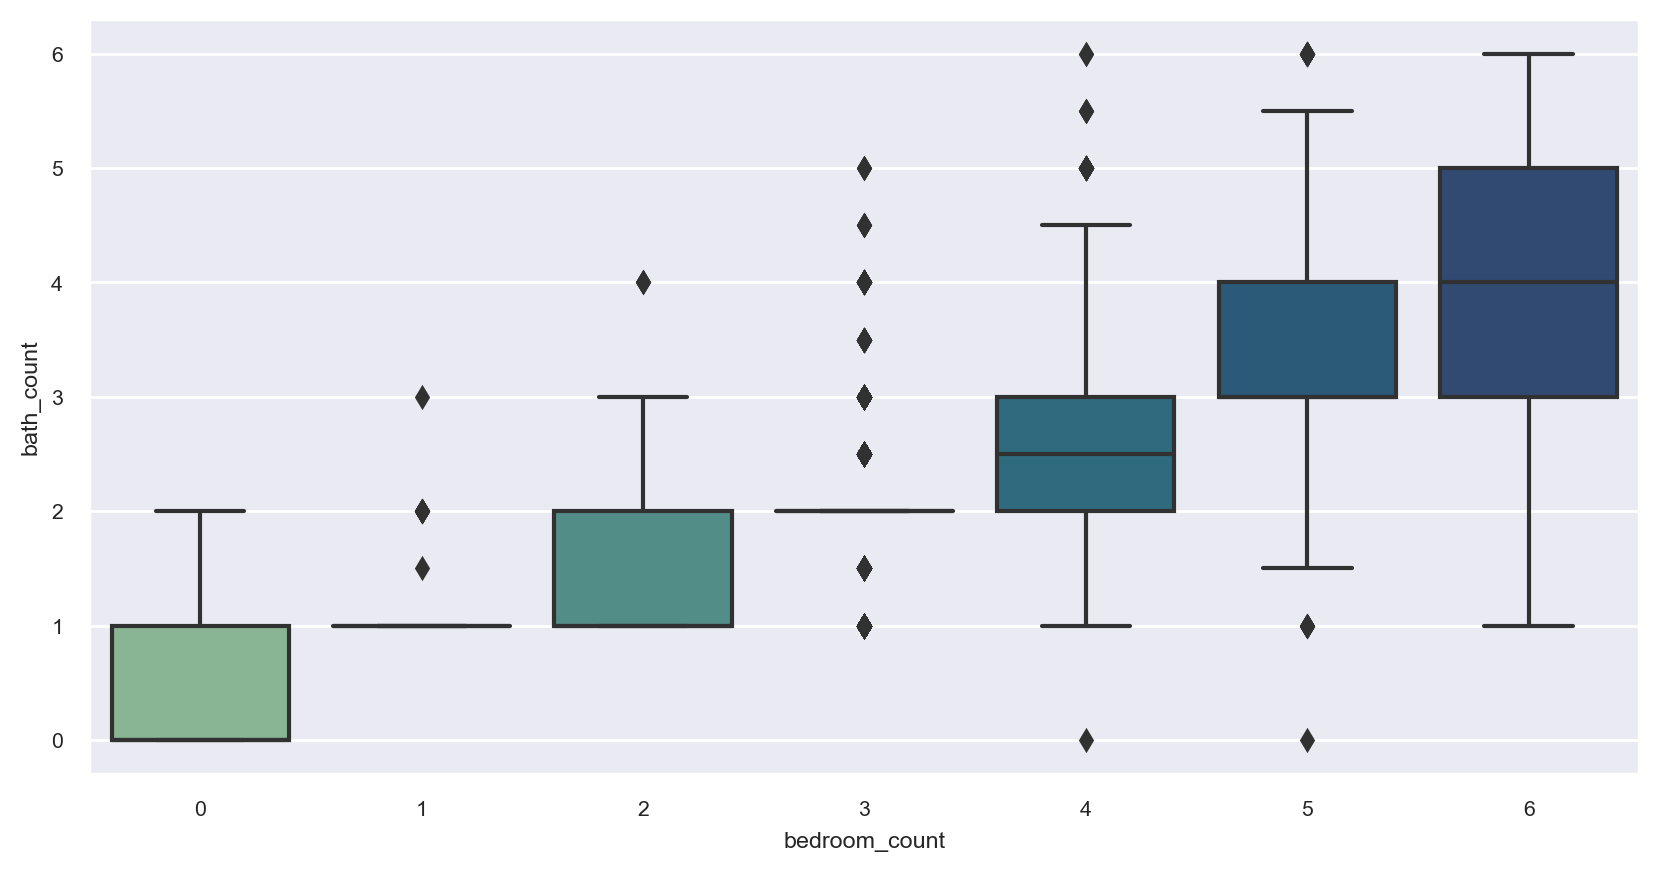

In [146]:
# plotting sample of bedroom count and bath count

plt.figure(figsize = (10, 5))
sns.set(style = "darkgrid", font_scale = 0.7)
sns.boxplot(x = "bedroom_count", y = "bath_count", data = X_train.sample(10000), palette = "crest")
plt.show()

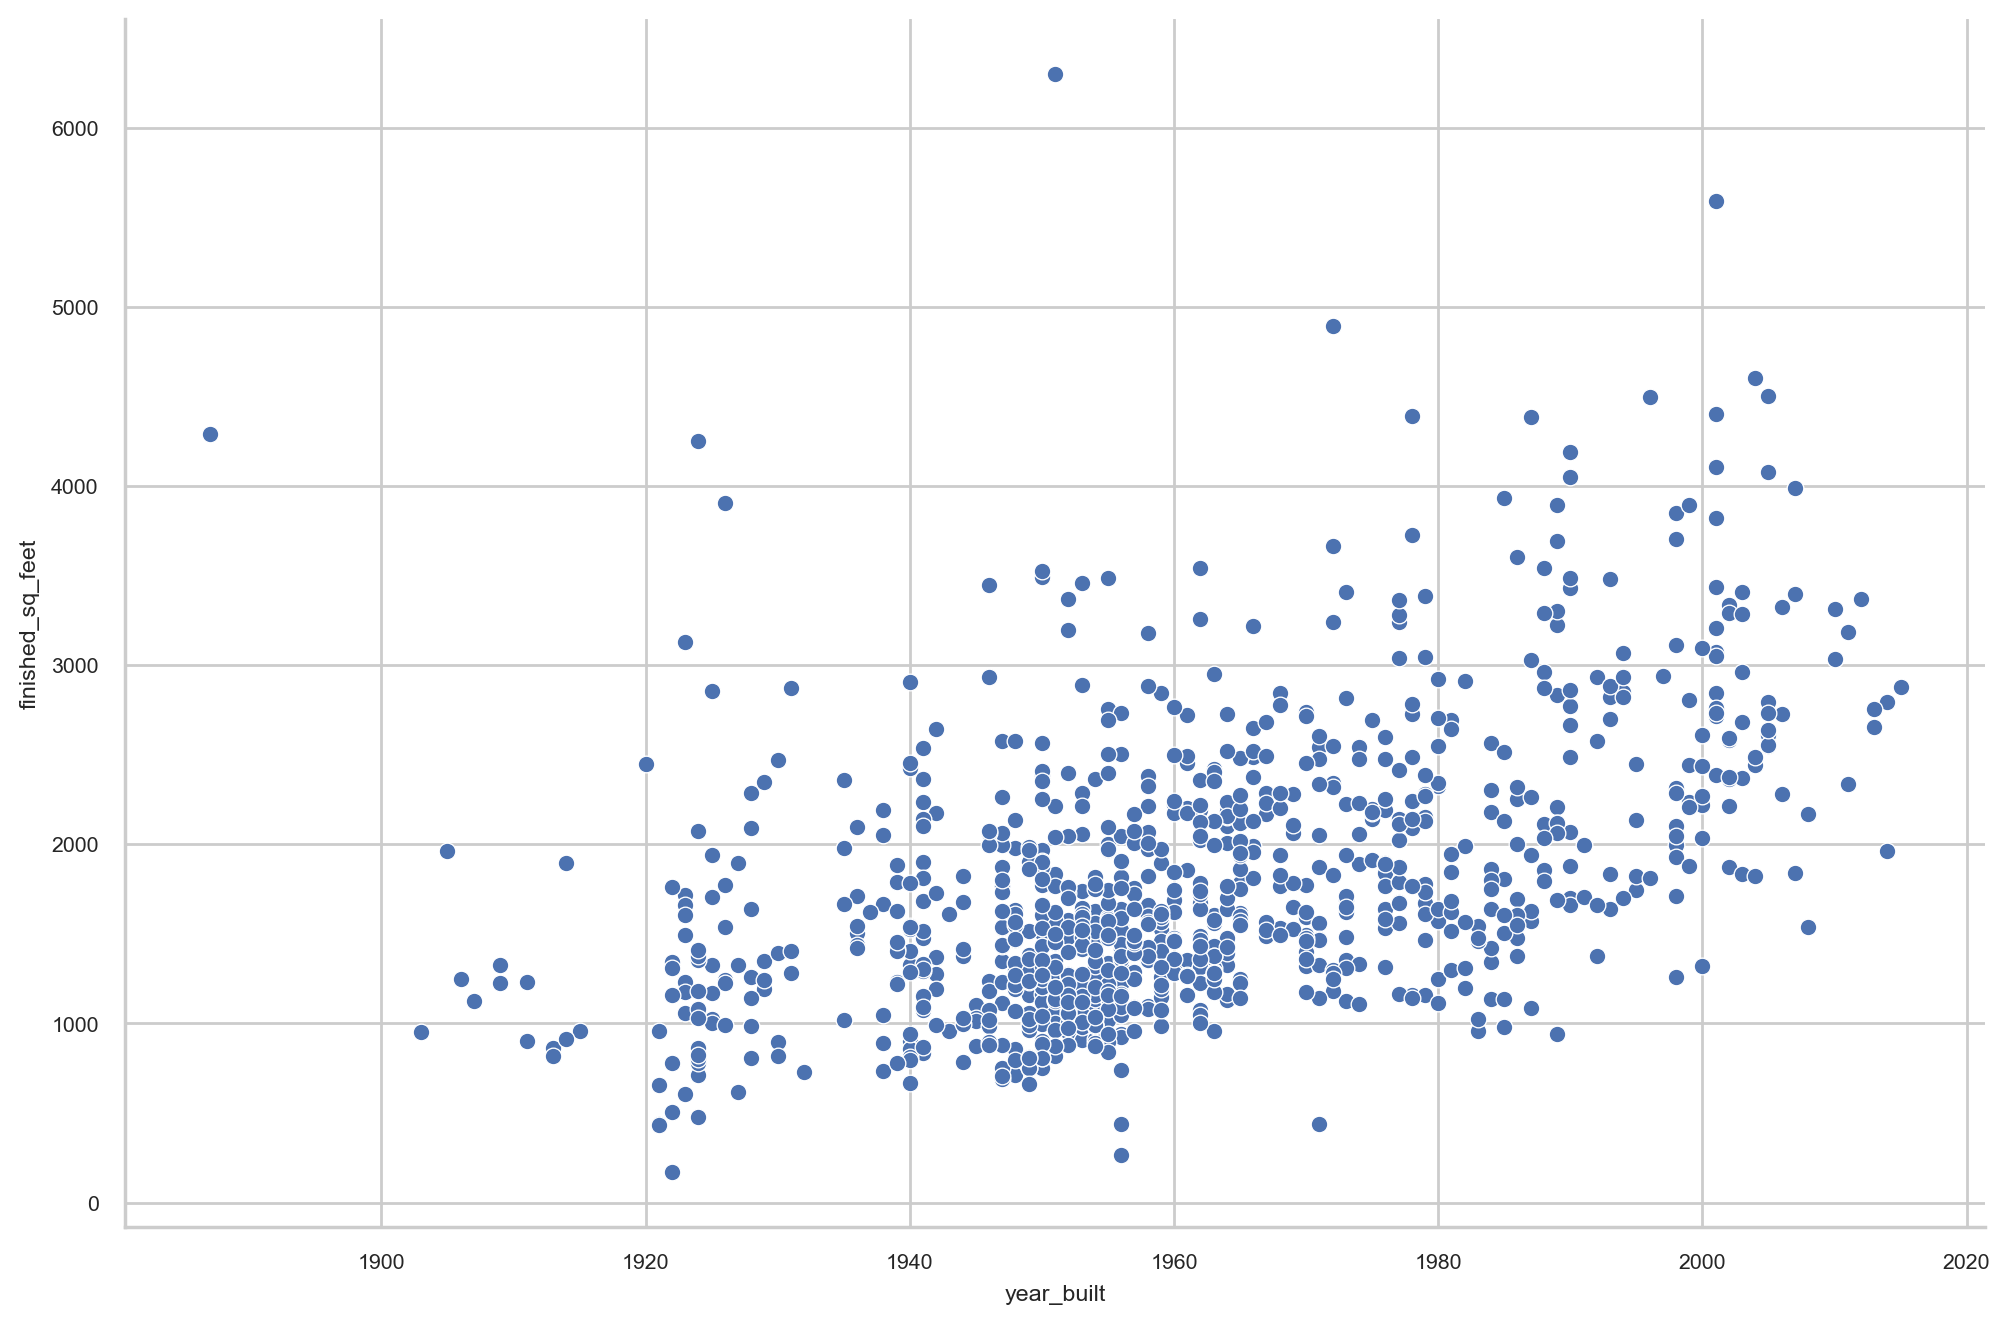

In [147]:
# plotting sample of finished_sq_feet and year_built

plt.figure(figsize = (12, 8))
sns.set(style = "whitegrid", font_scale = 0.7)

sns.scatterplot(x = "year_built", y = "finished_sq_feet", data = X_train.sample(1000))
sns.despine()
plt.show()

----
``3. Write a function named plot_variable_pairs that accepts a dataframe as input and plots all of the pairwise relationships along with the regression line for each pair.``


In [148]:
# seeing correlation among train dataset features

train.sample(10000).corr().T.round(4)

bedroom_count  bath_count  finished_sq_feet  year_built  \
bedroom_count            1.0000      0.6201            0.6201      0.3742   
bath_count               0.6201      1.0000            0.8121      0.5232   
finished_sq_feet         0.6201      0.8121            1.0000      0.4741   
year_built               0.3742      0.5232            0.4741      1.0000   
fips                     0.1450      0.1342            0.1516      0.3215   
tax_amount               0.2601      0.4749            0.5419      0.2914   
home_value               0.2639      0.4785            0.5504      0.2856   

                    fips  tax_amount  home_value  
bedroom_count     0.1450      0.2601      0.2639  
bath_count        0.1342      0.4749      0.4785  
finished_sq_feet  0.1516      0.5419      0.5504  
year_built        0.3215      0.2914      0.2856  
fips              1.0000      0.0641      0.1158  
tax_amount        0.0641      1.0000      0.9718  
home_value        0.1158      0.9718      1.0000

In [149]:
# changing the column order for easier readibility (placing target variable last)

cols = train.columns.tolist()
cols

['bedroom_count',
 'bath_count',
 'finished_sq_feet',
 'year_built',
 'fips',
 'tax_amount',
 'home_value']

In [150]:
# rearranging columns and setting it back to train df
# cols = [
#     'bedroom_count',
#     'bath_count',
#     'finished_sq_feet',
#     'year_built',
#     'fips',
#     'tax_amount',
#     'home_value']

# train = train[cols]

In [151]:
train.shape

(1156505, 7)

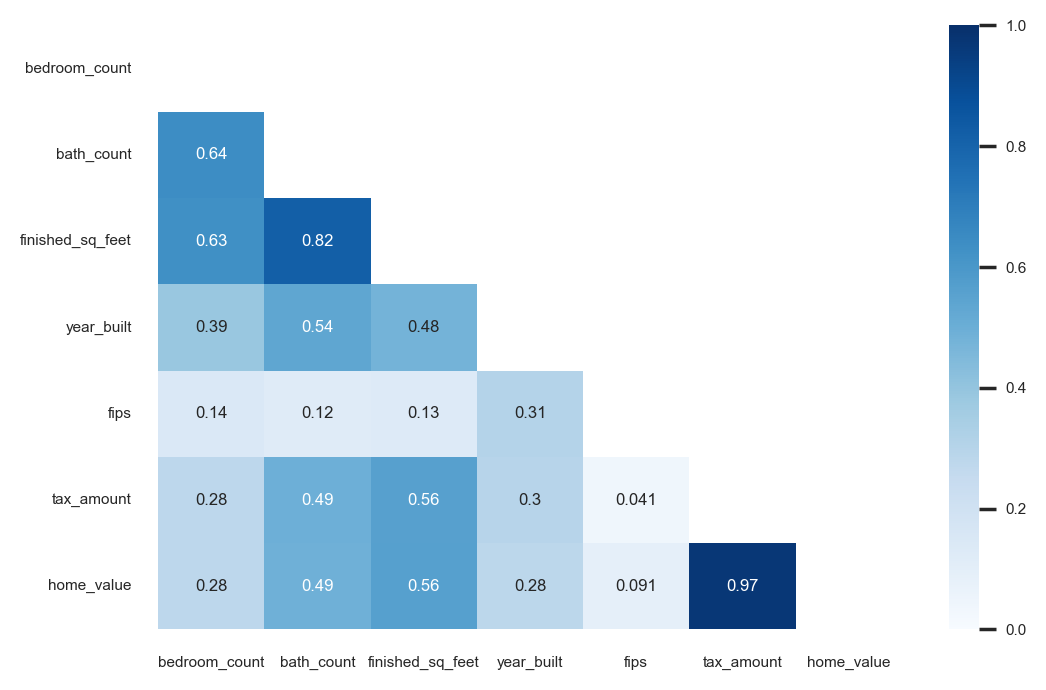

In [152]:
# using sns.heatmap to visualize the correlation among features

correlation_table = train.sample(10000).corr()
sns.set(style = "white", font_scale = 0.5)
sns.heatmap(correlation_table, cmap='Blues', annot=True, vmin=0, vmax=1, mask= np.triu(correlation_table))

plt.show()

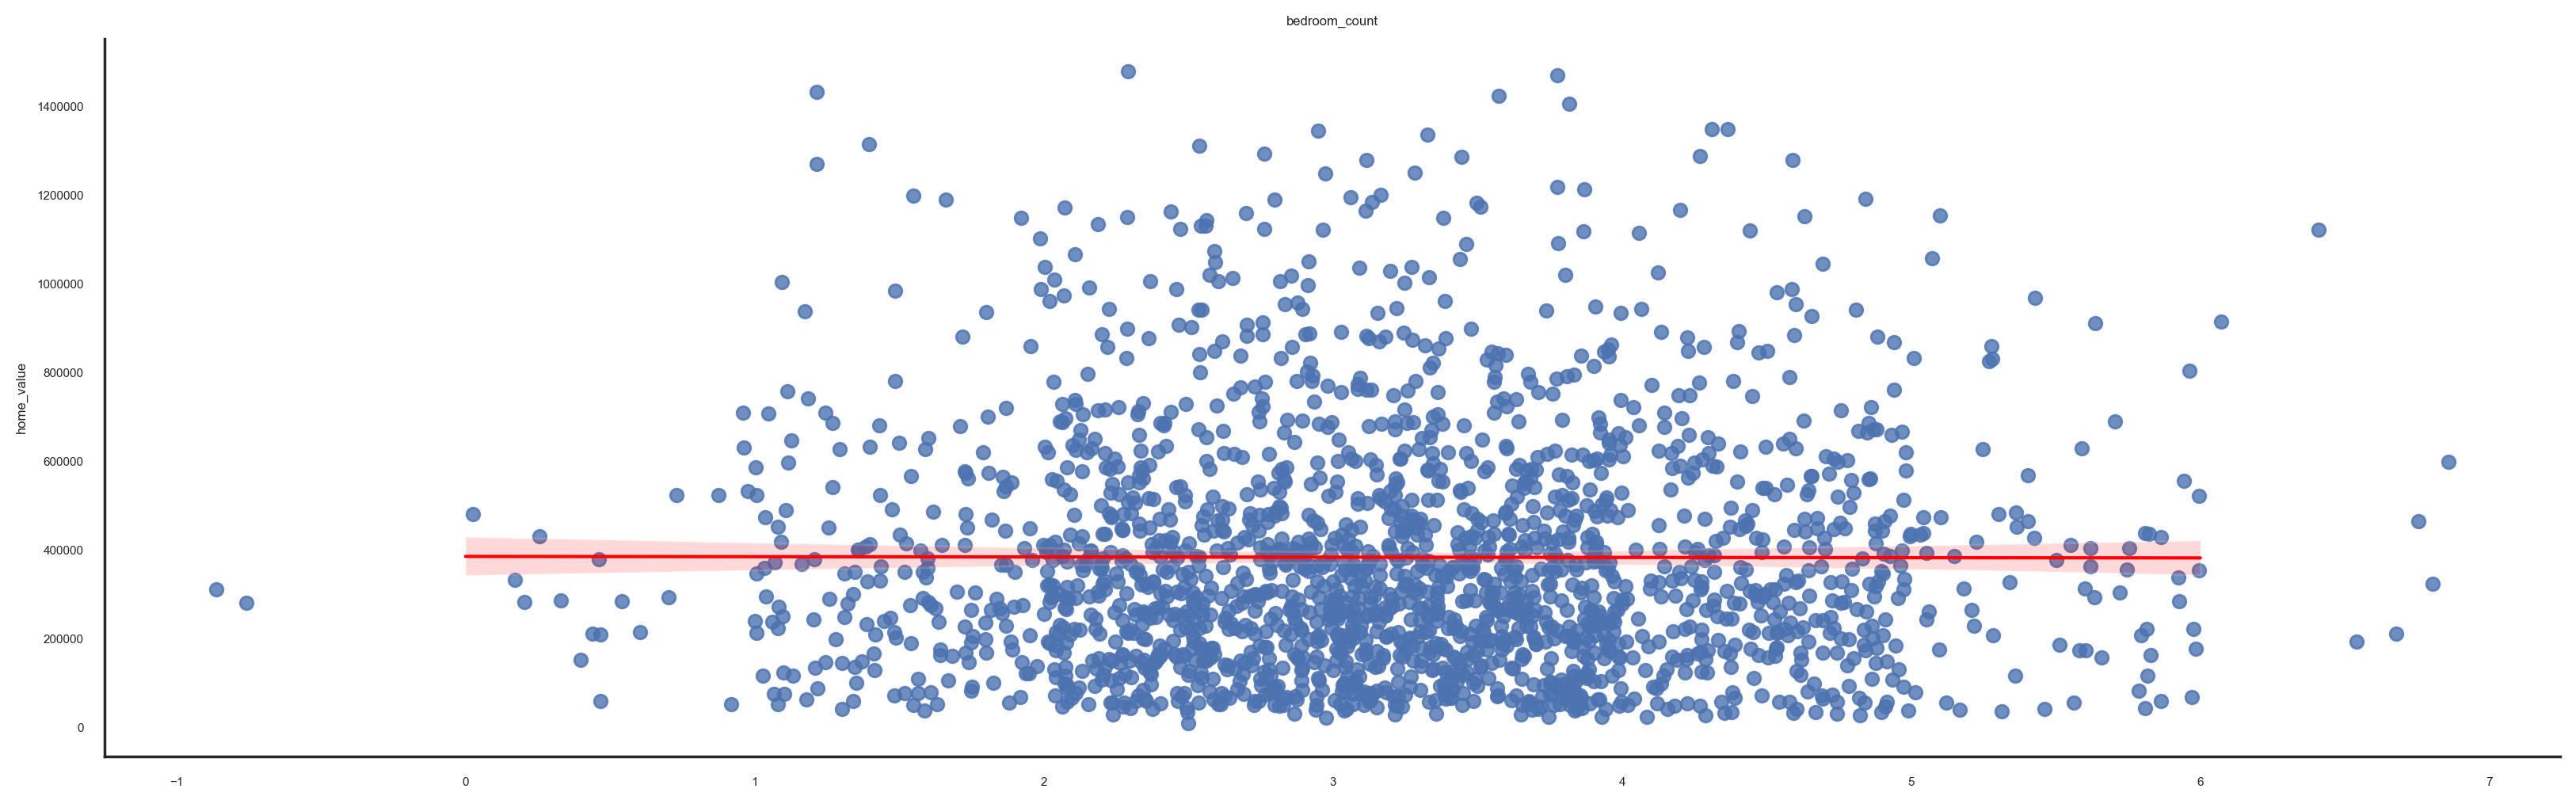

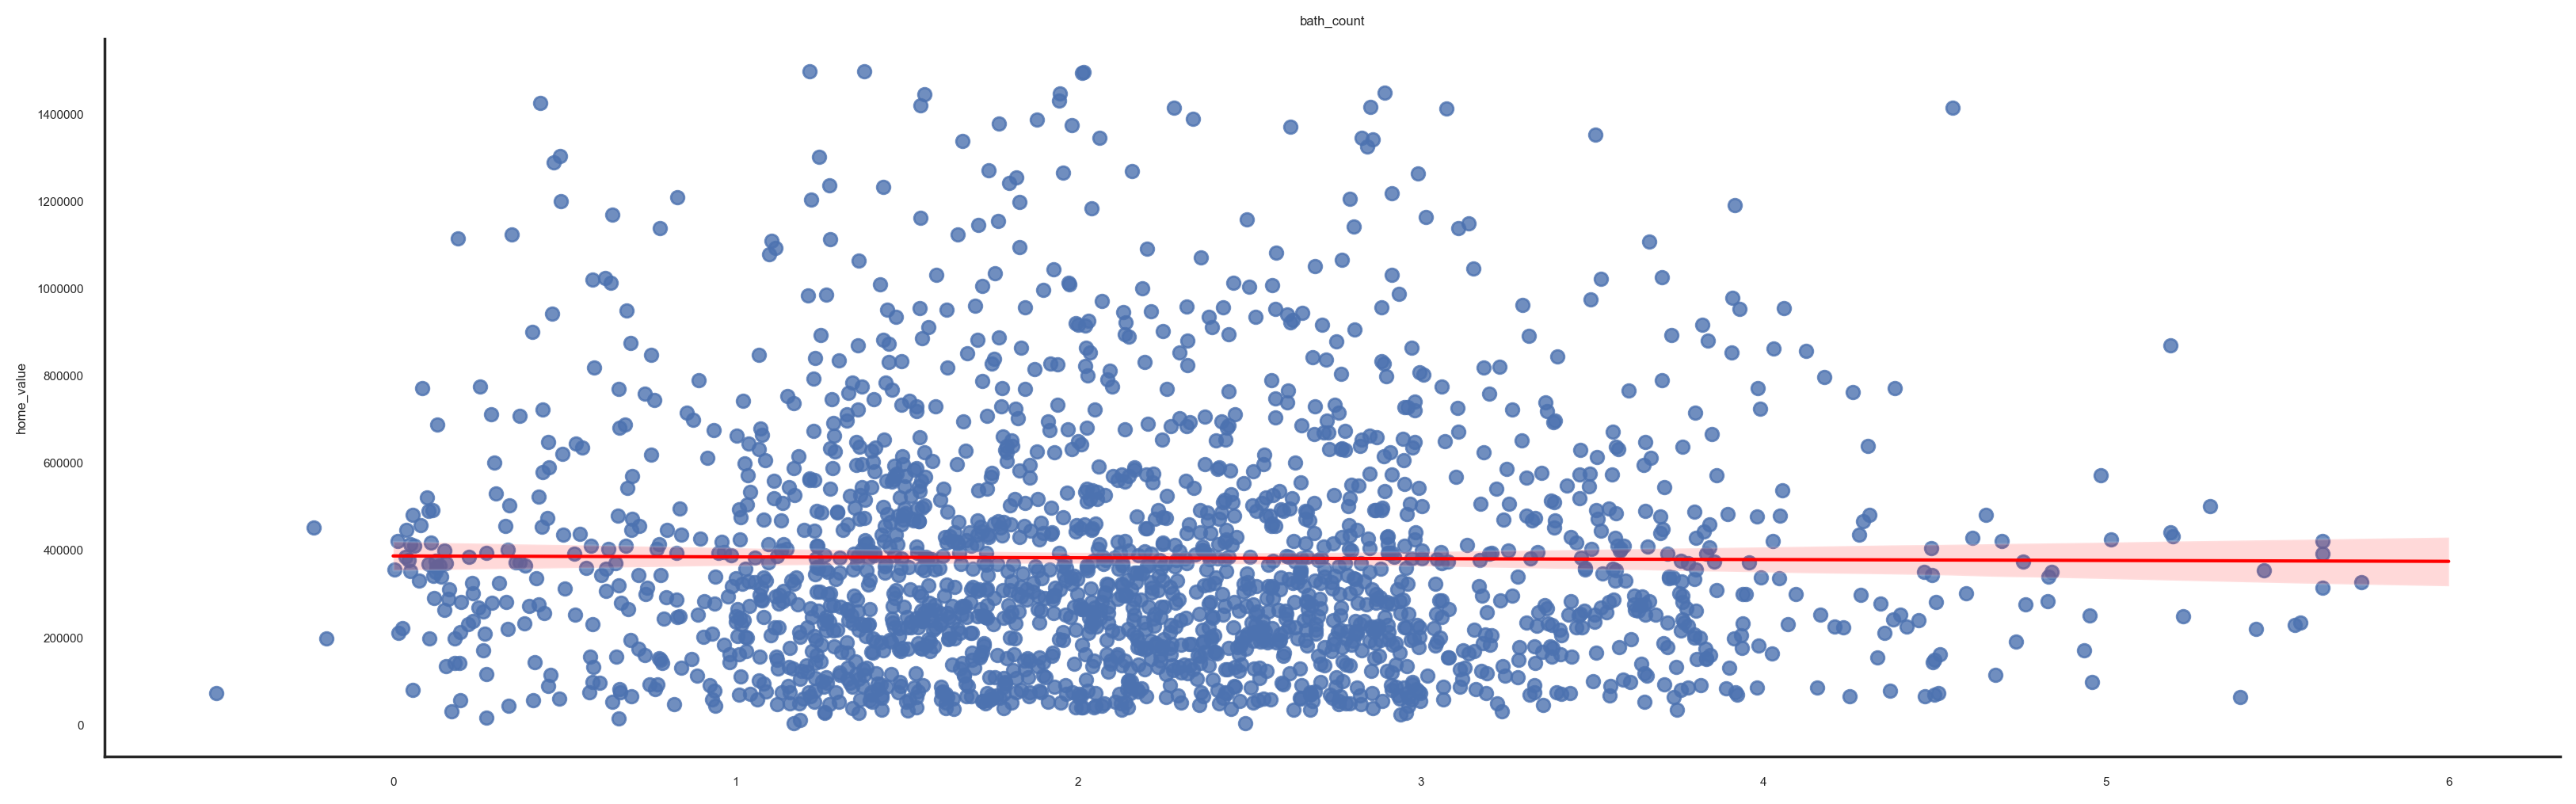

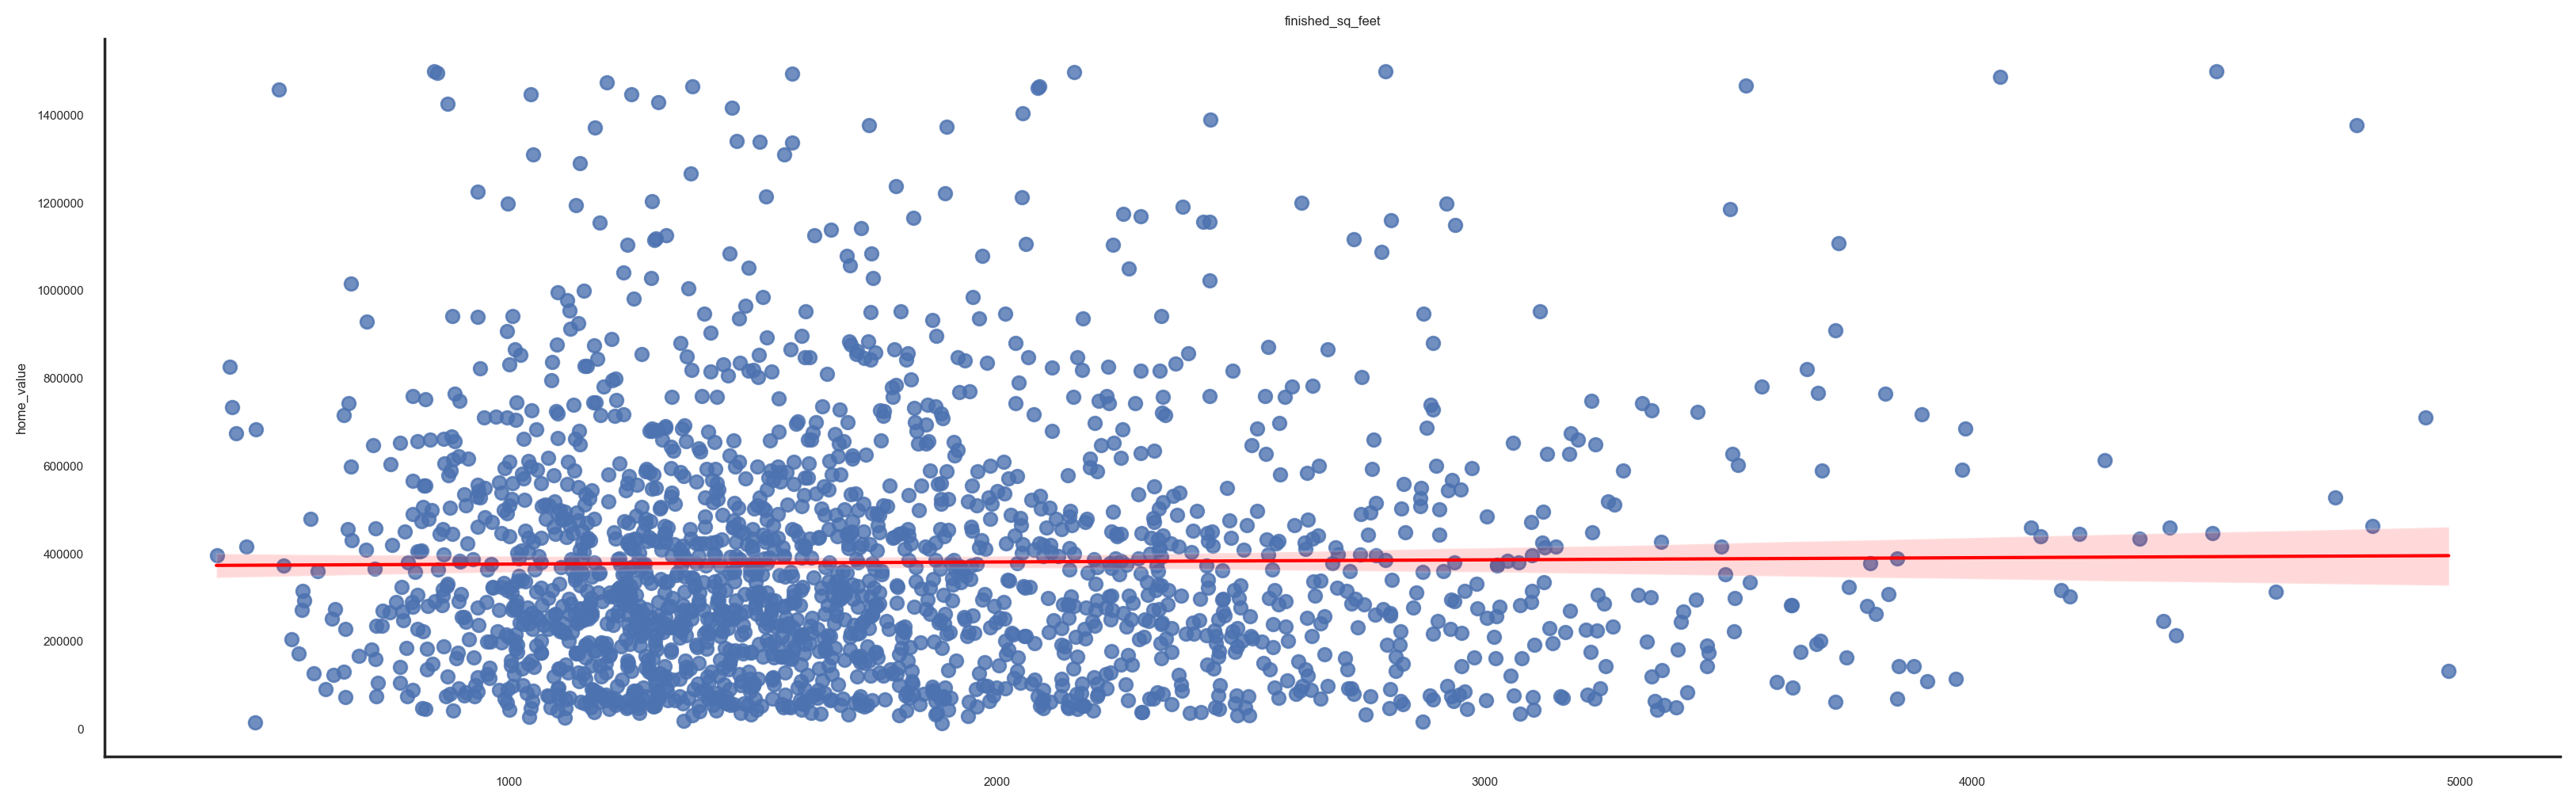

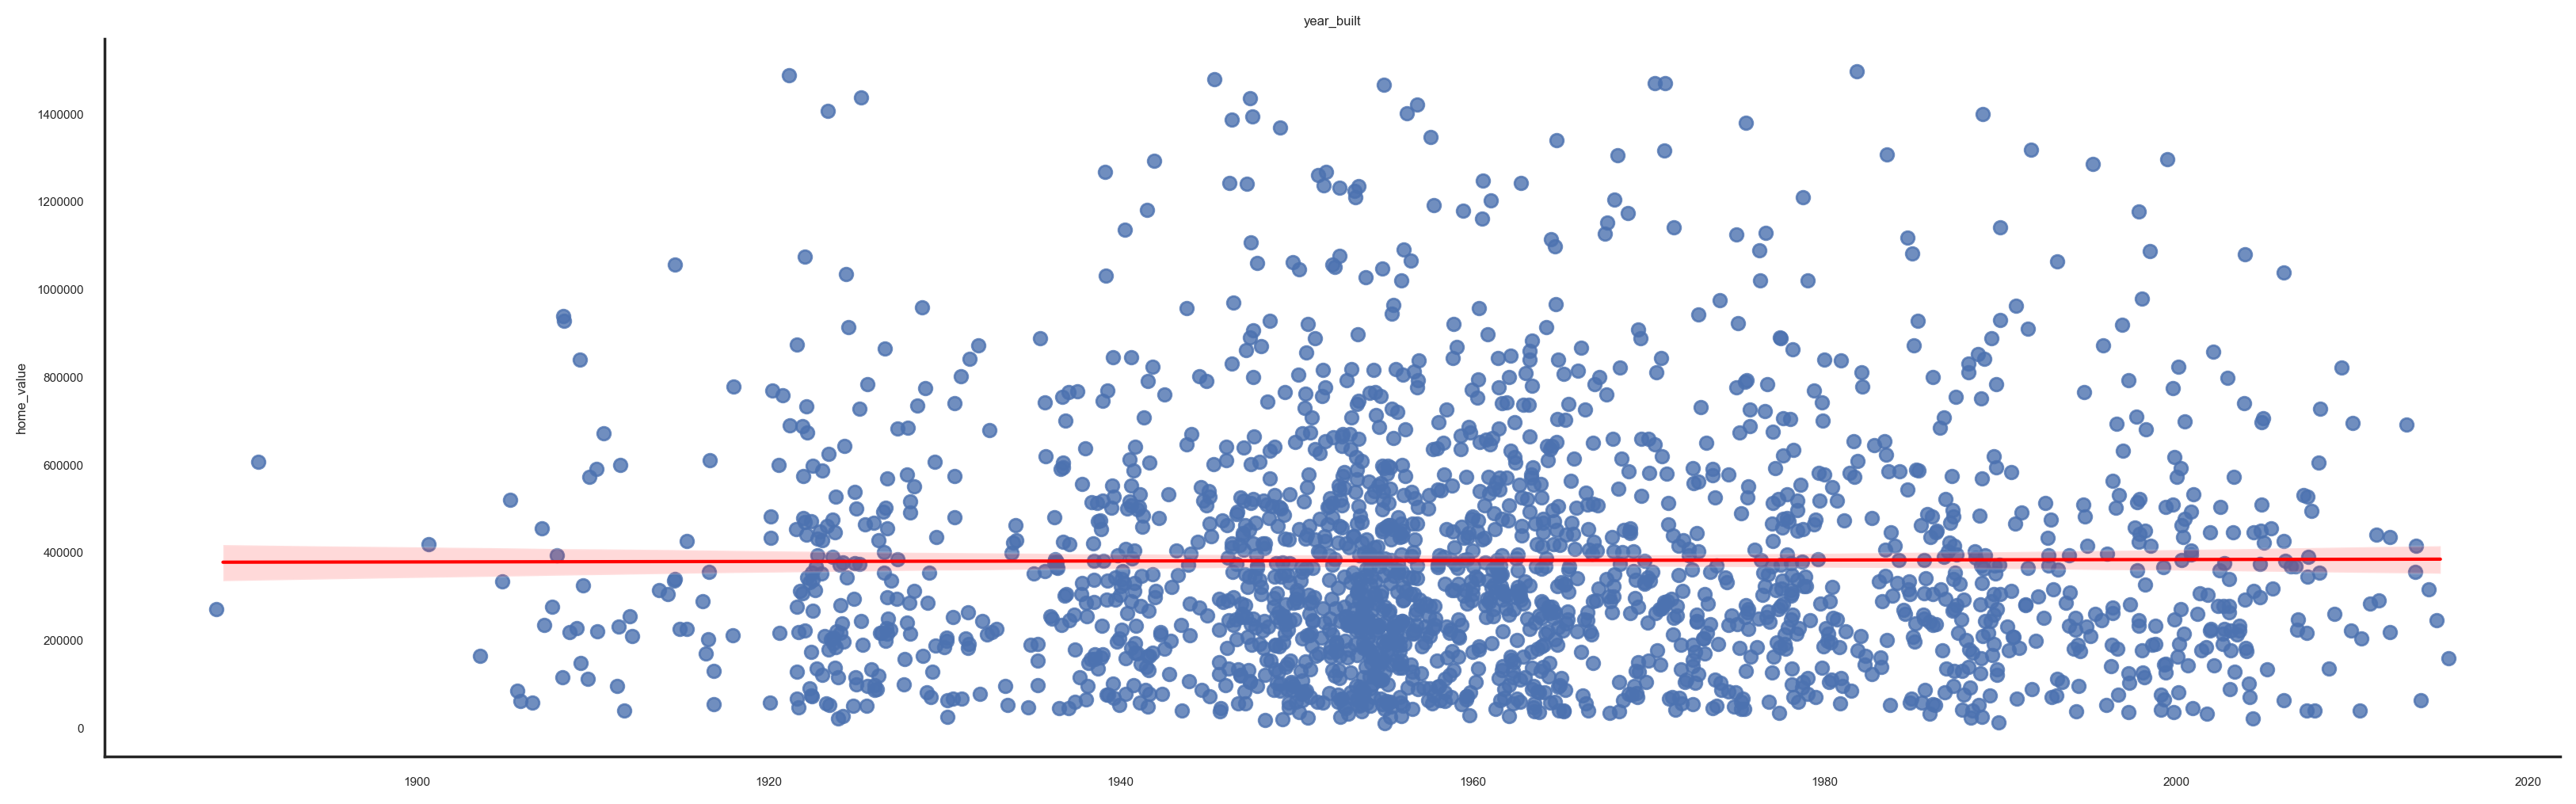

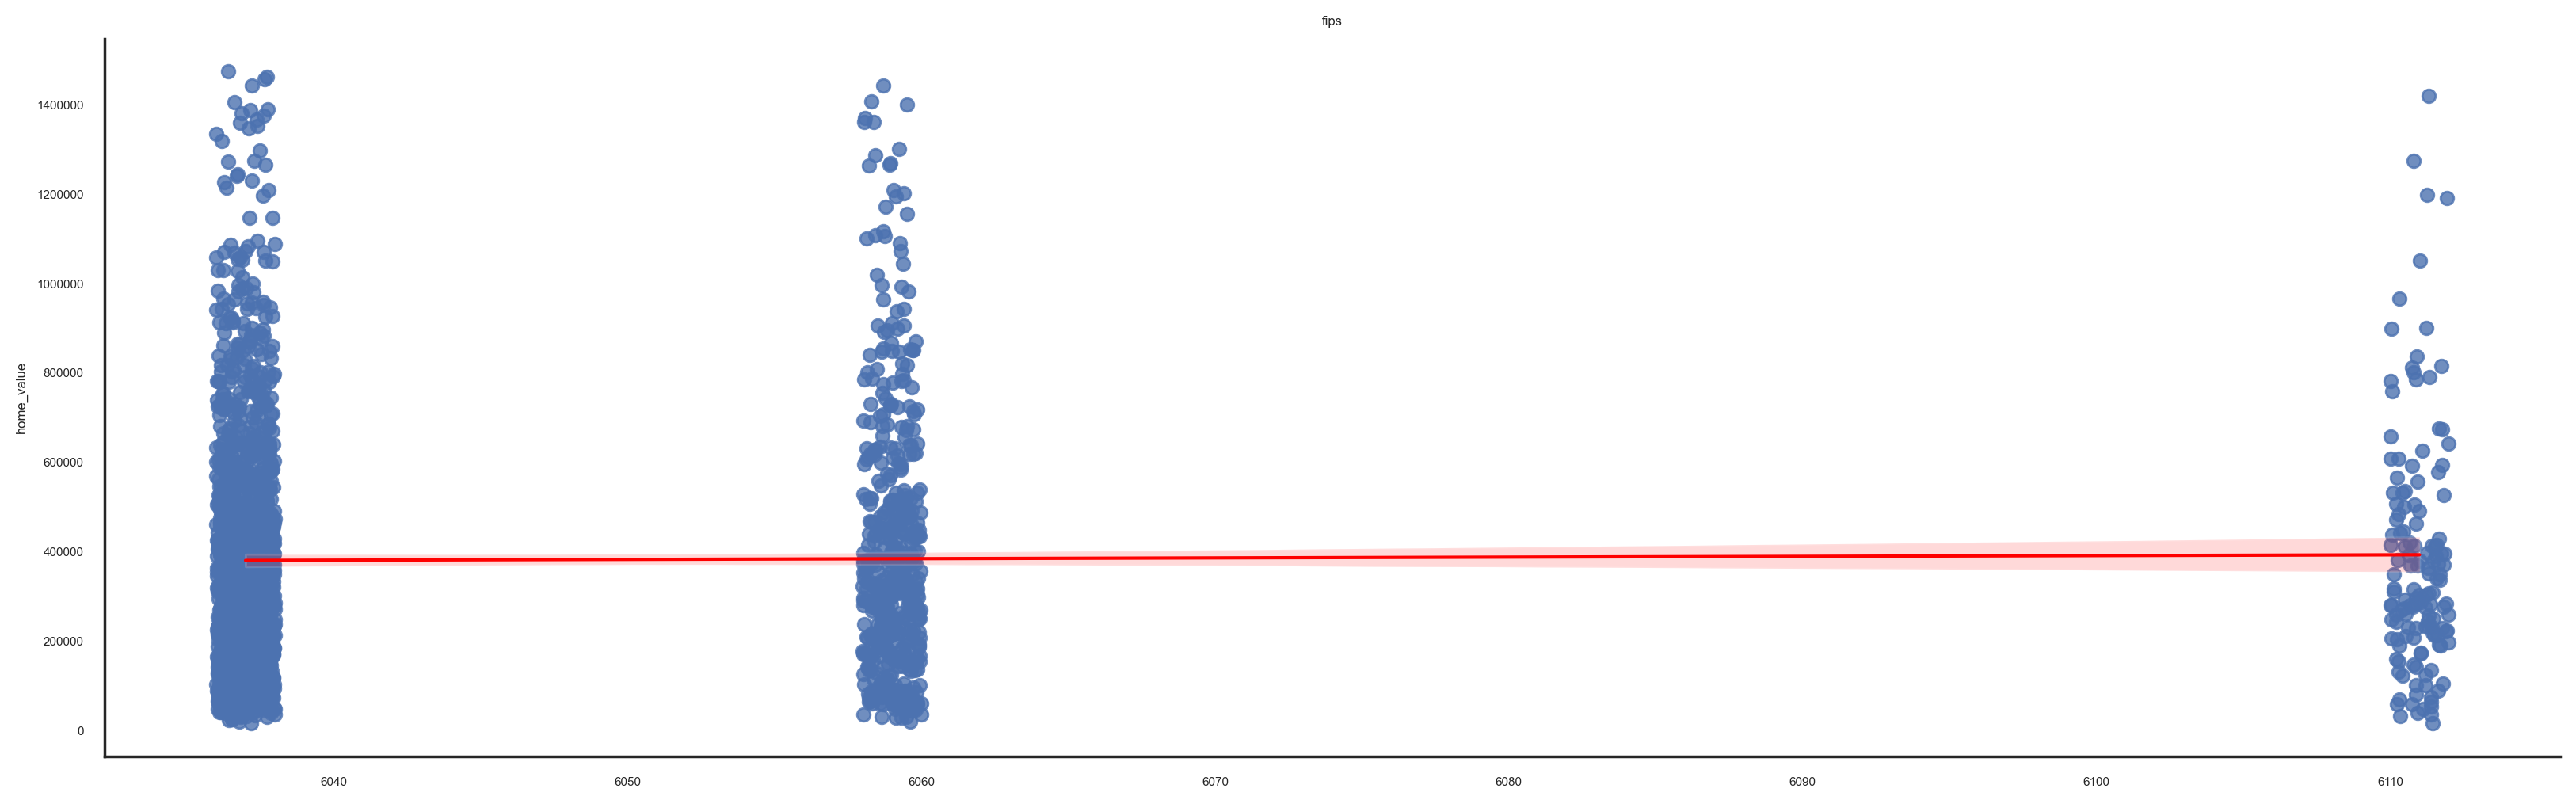

In [153]:
# plotting relationship/correlation for ea. feature and home_value (target variable)
# can now convert this into a "wrangle.py" function where: function takes in a dataframe and list, and plots them against target variable w/'line-of-best-fit'

cols = X_train.columns.to_list()

for col in cols:
    plt.figure(figsize = (10, 4))

    # plotting ea. feature against home value with added "independent jitter" for easier visual
    ax = sns.regplot(train[[col]].sample(2000), \
    y_train.sample(2000), \
    x_jitter = 1, # adding superficial noise to independent variables
    line_kws={
        "color": "red", 'linewidth': 1.5})
    
    ax.figure.set_size_inches(20, 6)
    sns.despine()
    # removing scientific notations
    ax.ticklabel_format(style = "plain")
    
    # removing x_axis label
    ax.set_xlabel(None)

    plt.title(col)
    plt.show()

----
4. Write a function named plot_categorical_and_continuous_vars that accepts your dataframe and the name of the columns that hold the continuous and categorical features and outputs 3 different plots for visualizing a categorical variable and a continuous variable.

In [154]:
train.columns

Index(['bedroom_count', 'bath_count', 'finished_sq_feet', 'year_built', 'fips',
       'tax_amount', 'home_value'],
      dtype='object')

In [155]:
# let's first identify all the discrete/categorical features and contineous features for testing the function

discrete_vars = ["bedroom_count", "year_built", "fips"]
continuous_vars = ["bath_count", "finished_sq_feet", "tax_amount", "home_value"]

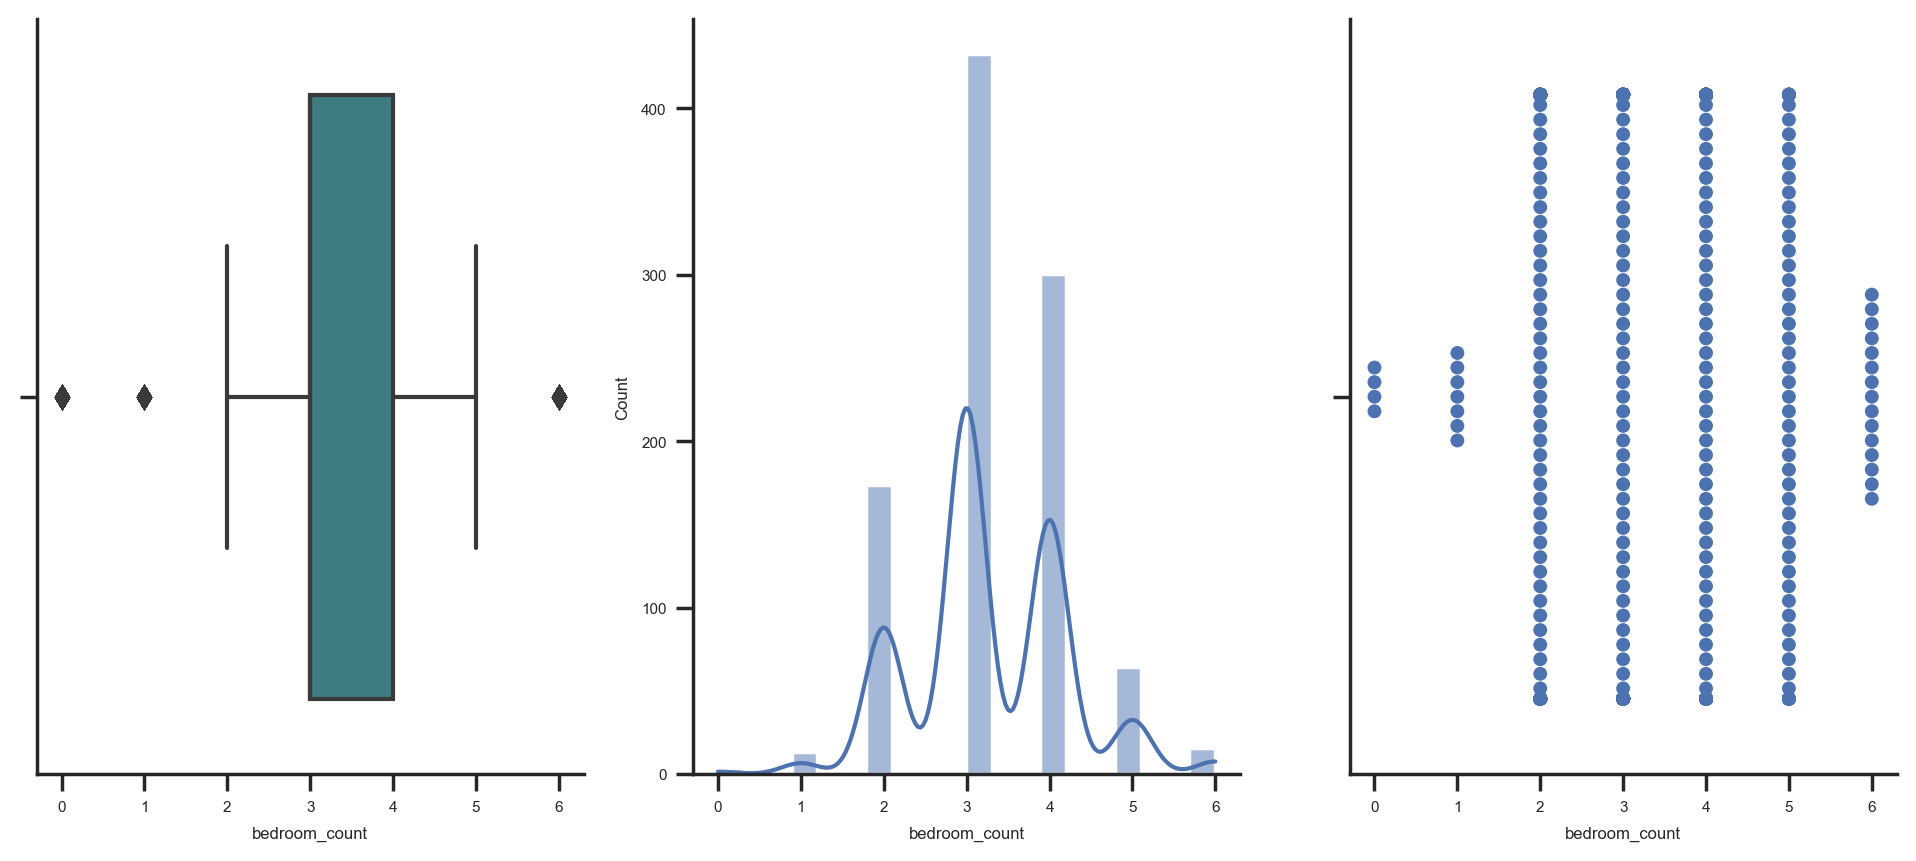

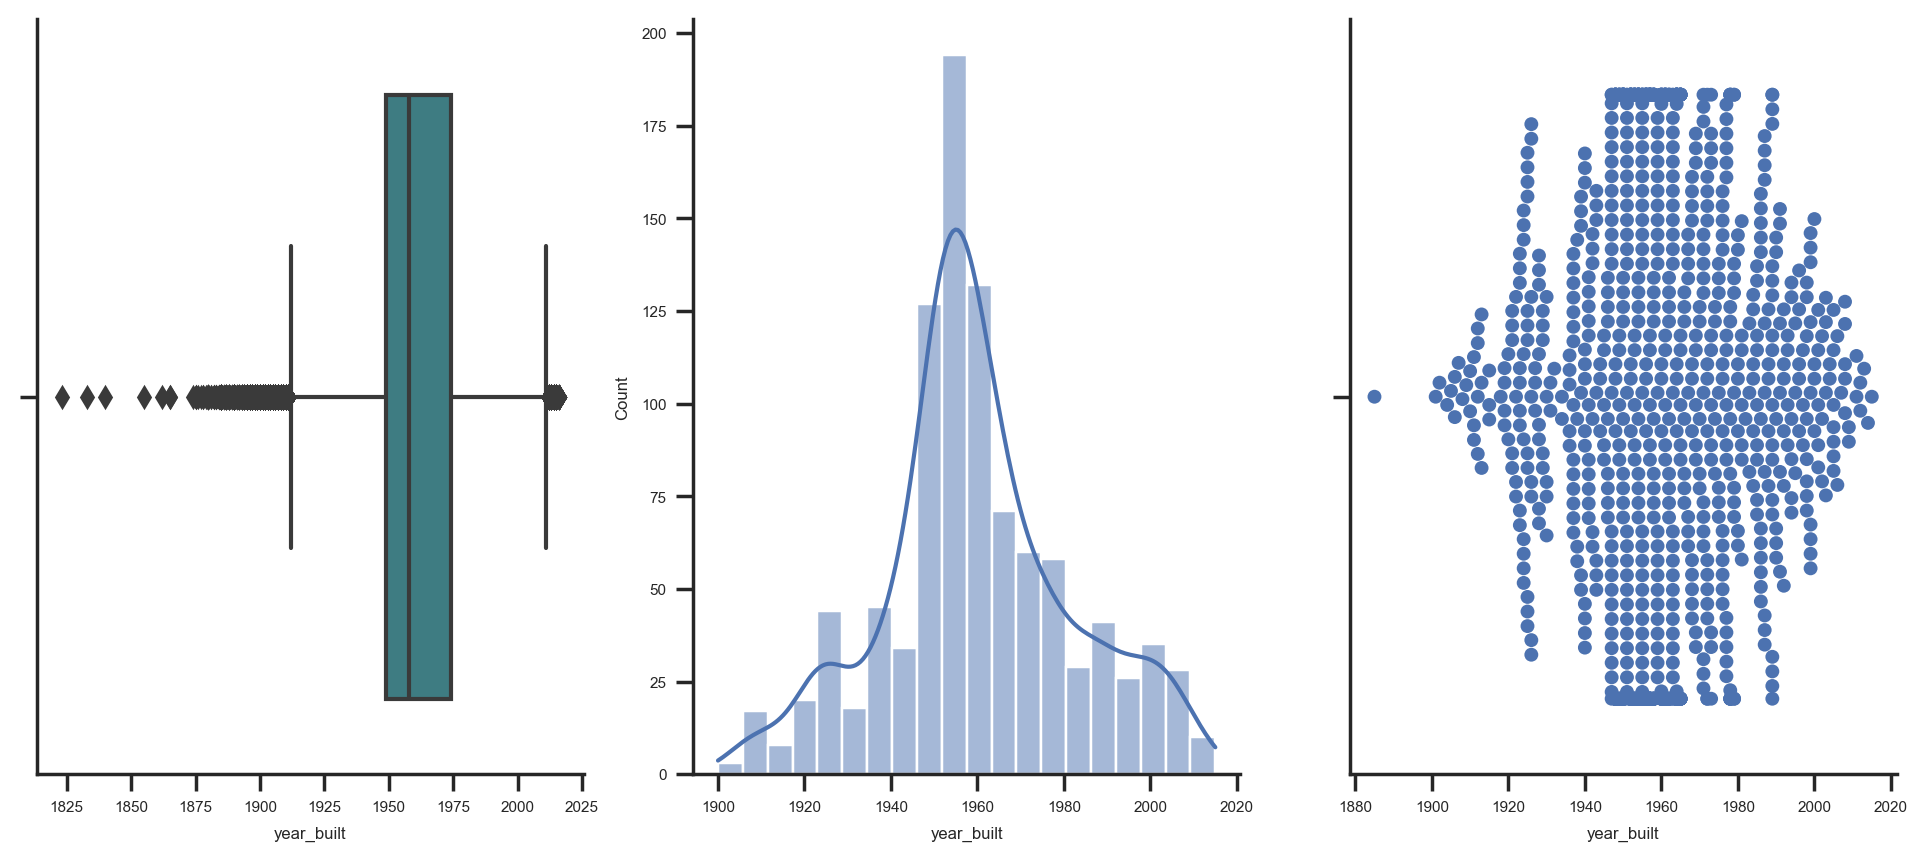

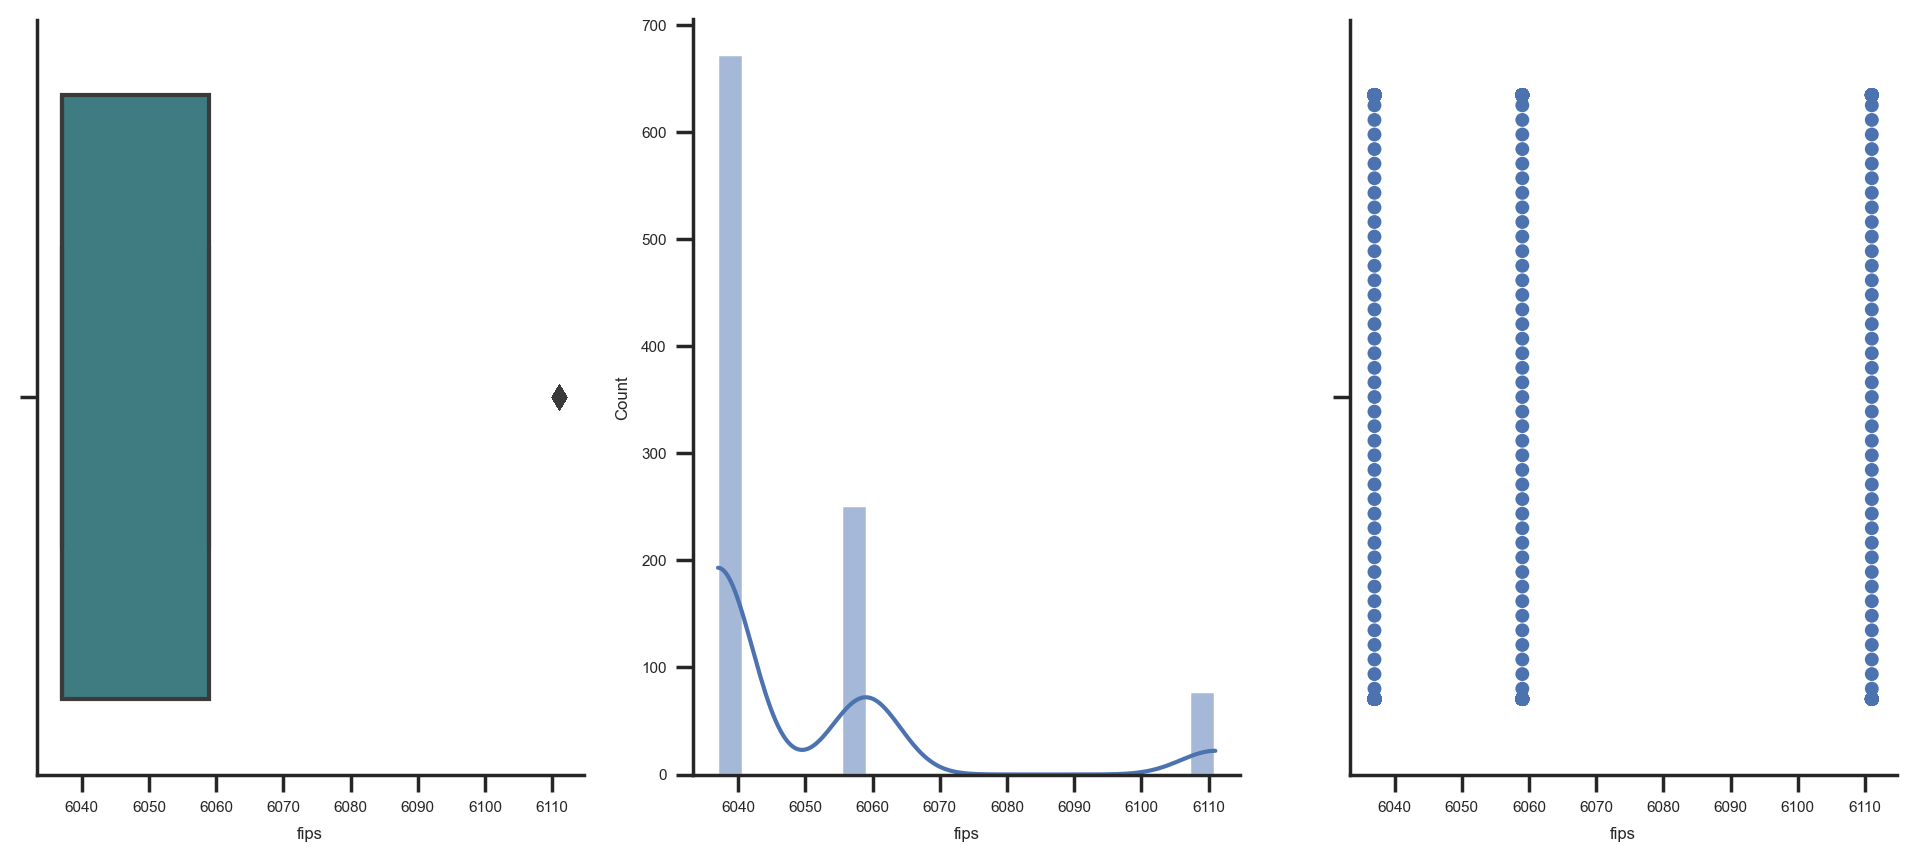

In [172]:

for col in train:
    
    if col in discrete_vars:
        # editing settings
        plt.figure(figsize = (12, 5))
        sns.set_style("ticks")

        # first discrete plot
        plt.subplot(131)
        sns.boxplot(x = train[col], data = train.sample(1000), palette = "crest")
        
        # second discrete plot
        plt.subplot(132)
        sns.histplot(train[col].sample(1000), palette = "crest_r", bins = 20, kde = True)

        # third discrete plot
        plt.subplot(133)
        ax = sns.swarmplot(train[col].sample(1000))
        # ax.figure.set_size_inches(18, 6)
        
        sns.despine()
        plt.show()